In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import sys
sys.path.append("..")
sys.path.append("../wishart/")
from wishart import wishart_lib, wishart_lib_stepan
from motifs import motifs

from indexes import indexes_lib
from generator import generator_lib
import numpy as np
from matplotlib import pyplot as plt
import importlib
from scipy.interpolate import make_interp_spline, BSpline

import sys
sys.path.append("..")
importlib.reload(wishart_lib_stepan)
importlib.reload(wishart_lib)
importlib.reload(indexes_lib)
importlib.reload(generator_lib)
importlib.reload(motifs)

<module 'motifs.motifs' from '/home/mrplotva/time_series/self-healing/../motifs/motifs.py'>

In [10]:
from collections import defaultdict
from motifs.motifs import GenerateAllMotifs, GenPatterns
import numpy as np
import pdb
import dill
# from sklearn.datasets.samples_generator import make_blobs
import random
from itertools import combinations, product
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
from math import sqrt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score
import seaborn as sn

In [11]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [12]:
lorents = Lorentz()
data, _, _ = Lorentz().generate(0.1, 100000)
data = data[250:]
data = (data - data.min()) / (data.max() - data.min())

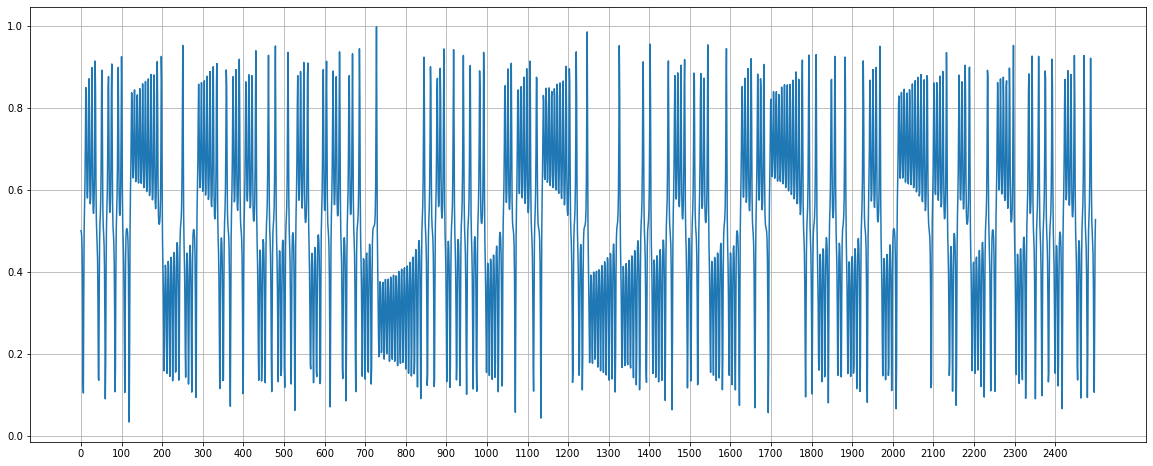

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(data[:2500])
plt.xticks([i for i in range(0, 2500, 100)])
plt.grid()
plt.show()

In [184]:
from statistics import mean
from wishart.wishart_lib import Wishart
TRAIN_SIZE = 15000
TEST_SIZE = 1000
size = len(data)
train_data = data[:TRAIN_SIZE]
test_data = data[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]
print(size)

99751


In [16]:
def get_val_for_pattern_and_pos(data: np.array, pattern: list, pos: int, bad):
    val = []
    sum = 0
    for i in range(len(pattern) - 1, -1, -1):
      sum += pattern[i]
      val.append(data[pos - sum])
      if bad[pos - sum]:
          return np.array([])
    val = val[::-1]
    return np.array(val)

def get_val_for_motifs(data: np.array, motif: list, bad):
    val = []
    for i in motif:
        val.append(data[i])
        if bad[i]:
            return np.array([])
    return np.array(val)

In [17]:
from itertools import groupby
WISHART_R = 10
WISHART_U = 0.2
def get_centers(x_train):
    N = len(x_train[0])
    wishart = Wishart(WISHART_R, WISHART_U)
    labels = wishart.fit(x_train)
    sorted_by_cluster = sorted(range(len(labels)), key=lambda x: labels[x])
    centers = []
    for wi, cluster in groupby(sorted_by_cluster, lambda x: labels[x]):
        if wi == 0:
            continue
        cluster = list(cluster)
        center = np.full(N, 0.0)
        for i in cluster:
            center += x_train[i]
        centers.append(center / len(cluster))

    return centers


def get_all_centers_for_patterns(data, L: int = 3, kmax: int = 10):
    centers = dict()
    t = len(data)

    bad = np.array([0 for i in range(t)])
    for pattern, all_motifs  in GenerateAllMotifs(kmax, L, t - 1):

        all_val = [get_val_for_motifs(data, motif, bad) for motif in all_motifs]
        centers[pattern] = get_centers(all_val)

        if len(centers) % 200 == 0:
            print(len(centers))

    return centers

In [18]:
def save_centers(centers, file):
    arr_to_save = []

    for key in centers:
        cur = [key, centers[key]]
        arr_to_save.append(cur)

    np.save(file, np.array(arr_to_save, dtype=object))
    # arr = np.load('centers.npy', allow_pickle=True)
    # return arr
    # print(arr)
    

In [20]:
# LOADING OF CENTERS DATA
# CHANGE IF NECESSARY TO REGENERATE
print(len(train_data))
need_to_generate = False

centers = []
if need_to_generate:
    centers = get_all_centers_for_patterns(train_data, L = 4)
    save_centers(centers)
else:
    data_c = np.load('../centers.npy', allow_pickle=True)
    centers = dict()
    for key, val in data_c:
        centers[key] = val

    # print(len(data[0][1]))

10000


In [22]:
print(centers[(1, 1, 1)])

[array([0.51282951, 0.52517655, 0.546495  , 0.59993112]), array([0.51803694, 0.53358407, 0.5640535 , 0.64009455]), array([0.50762698, 0.51472402, 0.52302257, 0.54250186]), array([0.50119488, 0.48790355, 0.45798518, 0.38076514]), array([0.50634028, 0.49218787, 0.46812191, 0.40840008]), array([0.51893039, 0.53897365, 0.57573132, 0.6647086 ]), array([0.51065723, 0.48092653, 0.44675276, 0.3730327 ]), array([0.69138134, 0.82629217, 0.8680333 , 0.73359038]), array([0.45971976, 0.48020555, 0.47047804, 0.43188438]), array([0.8219394 , 0.87286501, 0.73969399, 0.61094655]), array([0.4800662 , 0.44799222, 0.37360664, 0.21495321]), array([0.52450512, 0.54454345, 0.59440267, 0.72142823]), array([0.44766359, 0.37403133, 0.21587432, 0.09511249]), array([0.50816211, 0.51121782, 0.51449197, 0.52203855]), array([0.4457964 , 0.37723041, 0.23164454, 0.10317246]), array([0.56805643, 0.62363544, 0.74517216, 0.90014931]), array([0.54011352, 0.53749536, 0.557438  , 0.61371598]), array([0.53695148, 0.5689037 ,

In [14]:
# arr_to_save = []
#
# for key in centers:
#     cur = [key, centers[key]]
#     arr_to_save.append(cur)
#
# np.save('centers.npy', np.array(arr_to_save, dtype=object))
# arr = np.load('centers.npy', allow_pickle=True)
# print(arr)

In [23]:
from motifs.motifs import GenerateAllMotifs

In [24]:
class Daemon:
    def __init__(self, mode="simple", is_pred=True):
        self.mode = mode
        self.is_pred = is_pred

    def mean_d(self, preds):
        sum_weight = sum(map(lambda x: x[1], preds))
        s = sum(map(lambda x: x[0] * x[1], preds))
        return s / sum_weight
    
    def mean_q(self, preds):
        sum_weight = sum(map(lambda x: x[2], preds))
        s = sum(map(lambda x: x[0] * x[2], preds))
        return s / sum_weight
    
    def mean_d_q(self, preds):
        sum_weight = sum(map(lambda x: x[1] * x[2], preds))
        s = sum(map(lambda x: x[0] * x[1] * x[2], preds))
        return s / sum_weight
    
    
    def predict(self, possible_values):
        if self.is_pred and not self.is_predictable(possible_values):
            return None
        if self.mode == "simple":
            return np.mean(list(map(lambda x: x[0], possible_values)))
        elif self.mode == "simple_d":
            return self.mean_d(possible_values)
        elif self.mode == "simple_q":
            return self.mean_q(possible_values)
        else:
            return self.mean_d_q(possible_values)
        # return self.mean_q(self.possible_values)
        
    def is_predictable(self, possible_values):
        wishart = Wishart(WISHART_R, WISHART_U)
        labels = (wishart.fit([[i[0]] for i in possible_values]))
        # print(labels) 
        if len(set(labels)) > 3:
            return False
        # print(possible_values)
        # if max(np.array(possible_values)[:,0]) - min(np.array(possible_values)[:,0]) > 0.1:
        #     return False
        return True

In [25]:
class IdealDeamon(object):
    def __init__(self, real_vals, eps=0.05, mode='simple'):
        self.eps = eps
        self.mode = mode 
        self.real_vals=real_vals
        # self.predictions = po
        
    @property
    def label(self):
        return 'Ideal model of demon'

    def predict(self, start_point, step, prediction):
        if abs(prediction - self.real_vals[start_point + step]) > self.eps:
            return None
        return prediction
    
    def is_predictable(self, start_point, step, prediction):
       return abs(prediction - self.real_vals[start_point + step]) <= self.eps

In [44]:
from tqdm import tqdm


# def get_val_for_pattern_and_pos(data: np.array, pattern: list, pos: int, bad):
#     val = []
#     def get_predictions(self):
#        return self.predictions
#     sum = 0
#     for i in range(len(pattern) - 1, -1, -1):
#       sum += pattern[i]
#       val.append(data[pos - sum])
#       if bad[pos - sum]:
#           return np.array([])
#     val = val[::-1]
#     return np.array(val)


def get_val_for_pattern_and_pos(data: np.array, pattern: list, pos: int, bad, pred_pos: int = -1):
    sum = 0

    if pred_pos == -1:
        pred_pos = pos
        
    if not bad[pos] or pred_pos == pos:
        val = [data[pos]]
    else:
        return np.array([])
    
    for i in range(len(pattern) - 1, -1, -1):
        sum += pattern[i]
        val.append(data[pos - sum])
        if bad[pos - sum] and pred_pos != pos:
            return np.array([])
    val = val[::-1]
    return np.array(val)


def get_val_for_motifs(data: np.array, motif: list, bad):
    val = []
    for i in motif:
        val.append(data[i])
        if bad[i]:
            return np.array([])
    return np.array(val)

def base_prediction(data, daemon: Daemon, h: int, L: int = 3, kmax: int = 10, eps: float = 0.1, QVALUE = 0.99,
                    return_possible_values=False):
    t = len(data)
    prediction = np.zeros(shape=(t + h, 2))
    bad = np.array([0 for i in range(t + h)])
    for i in range(t):
        prediction[i][0] = data[i]
        prediction[i][1] = 1
    possible_values = [[] for i in range(h)]

    steps = 0
    for i in range(h):
        for pattern in GenPatterns(L - 1, kmax):
            val_for_pattern_with_q = get_val_for_pattern_and_pos(prediction, pattern, t + i, bad)
            if len(val_for_pattern_with_q) == 0:
                continue
            val_for_pattern = val_for_pattern_with_q[:, 0]
            val_q = val_for_pattern_with_q[:, 1]

            for c in centers[pattern]:
                if len(c) == 0:
                    continue
                steps += 1
                dist = np.linalg.norm(np.delete(c, -1) - np.delete(val_for_pattern, -1))
                if dist < eps:
                    weight_d = (eps - dist) / eps;
                    weight_q = np.mean(val_q) * QVALUE
                    possible_values[i].append([c[-1], weight_d, weight_q])
                #   possible_values[i].append([c[-1], weight_d, weight_q])
                
        if len(possible_values[i]):
            pred = daemon.predict(possible_values[i])
            if pred is not None:
                prediction[t + i][0] = pred
            else:
                bad[t + i] = 1
                prediction[t + i][0] = 0
        else:
            bad[t + i] = 1
            prediction[t + i][0] = 0

        prediction[t + i][1] = np.mean(list(map(lambda x: x[2], possible_values[i])))
    print(steps)
    if return_possible_values:
        return [prediction, bad, possible_values]
    return [prediction, bad]




In [192]:
def visualize_predictions(train_data, prediction_, test_data, h, bad_, axs=None, label = 'prediction'):
    # plt.figure(figsize=(18, 12))
    # plt.plot(list(train_data), 'g', label='prediction')
    prediction = prediction_.copy()
    bad = bad_.copy()
    if axs == None:
        # print(prediction[-h:])
        # print(bad[-h:])
        for i in range(len(bad)):
            if bad[i]:
                prediction[i] = float('nan')
        plt.figure(figsize=(18, 12))
        l, = plt.plot(prediction[-h:][:,0], 'r', label=label)
        # plt.plot(list(test_data[:h]), 'b', label='test')
        plt.legend(loc='best')
        # plt.scatter(list(range(0, h)), list(prediction[-h:]), s=50, c='r', label='prediction')
        # # plt.plot(test_data, 'b', label='prediction')
        plt.show()
    else:
        # print(bad[-h:])
        # axs.figure(figsize=(18, 12))
        axs.plot(prediction[-h:][:,0], 'r', marker='o', 
            markersize=4, label='prediction')
        axs.plot(list(test_data[:h]), 'b', label='test')
        axs.grid()
        axs.legend(loc='best')

In [48]:
def base_prediction_ideal(data, daemon: Daemon, ideal_daemon: IdealDeamon, h: int, L: int = 3, kmax: int = 10, eps: float = 0.1, QVALUE = 0.99,
                    return_possible_values=False):
    t = len(data)
    prediction = np.zeros(shape=(t + h, 2))
    bad = np.array([0 for i in range(t + h)])
    for i in range(t):
        prediction[i][0] = data[i]
        prediction[i][1] = 1
    possible_values = [[] for i in range(h)]

    steps = 0
    for i in range(h):

        for pattern in GenPatterns(L - 1, kmax):
            val_for_pattern_with_q = get_val_for_pattern_and_pos(prediction, pattern, t + i, bad)
            if len(val_for_pattern_with_q) == 0:
                continue
            val_for_pattern = val_for_pattern_with_q[:, 0]
            val_q = val_for_pattern_with_q[:, 1]


            for c in centers[pattern]:
              if len(c) == 0:
                  continue
              steps += 1
              dist = np.linalg.norm(c[:-1] - val_for_pattern[:-1])
              if dist < eps:
                  weight_d = (eps - dist) / eps;
                  weight_q = np.mean(val_q) * QVALUE
                  possible_values[i].append([c[-1], weight_d, weight_q])
                #   possible_values[i].append([c[-1], weight_d, weight_q])
                
        if len(possible_values[i]):
            pred = ideal_daemon.predict(0, i, daemon.predict(possible_values[i]))
            if pred is not None:
                prediction[t + i][0] = pred
            else:
                bad[t + i] = 1
                prediction[t + i][0] = 0
        else:
            bad[t + i] = 1
            prediction[t + i][0] = 0

        prediction[t + i][1] = np.mean(list(map(lambda x: x[2], possible_values[i])))
        # print(prediction[t + i])
    print(steps)
    return [prediction, bad, possible_values]




# base_prediction(test_data[-40:], 5)


In [199]:
def iterate_prediction(prediction, bad, iterations: int, data, daemon: Daemon, ideal_daemon: IdealDeamon, h: int, L: int = 3, kmax: int = 10, eps: float = 0.1, QVALUE = 0.99,
                    return_possible_values=False):
    t = len(data)
    steps = 0
    for i in range(len(prediction)):
        prediction[i][1] = 1
    for it in range(iterations):
        possible_values = [[] for i in range(h)]
        for i in range(h):
            # print(bad[t + i])
            # if not bad[t + i]:
            #     continue
            for pattern in GenPatterns(L - 1, kmax):
                for pos in range(L):
                    end_index = t + i + sum(pattern[pos:])
                    if len(prediction) <= end_index:
                        continue
                    val_for_pattern_with_q = get_val_for_pattern_and_pos(prediction, pattern, 
                                                                         pos=end_index, bad=bad, pred_pos=t + i)
                    
                    # print(t + i)
                    # print(pattern)
                    # print(end_index)

                    if len(val_for_pattern_with_q) == 0:
                        continue
                    val_for_pattern = val_for_pattern_with_q[:, 0]
                    val_q = val_for_pattern_with_q[:, 1]


                    for c in centers[pattern]:
                        if len(c) == 0:
                            continue
                        steps += 1
                        dist = np.linalg.norm(np.delete(c, pos) - np.delete(val_for_pattern, pos))
                        if dist < eps:
                            # print(c, val_for_pattern, pos)
                            weight_d = (eps - dist) / eps;
                            weight_q = np.mean(val_q) * QVALUE
                            possible_values[i].append([c[pos], weight_d, weight_q])
                    #   possible_values[i].append([c[-1], weight_d, weight_q])
                    
            # if bad[t + i]:
            #     print(t + i)
            if len(possible_values[i]):
                pred = ideal_daemon.predict(0, i, daemon.predict(possible_values[i]))
                # print(ideal_daemon.real_vals[i], daemon.predict(possible_values[i]))
                print(prediction[t + i], bad[t + i], pred)
                if pred is not None:
                    prediction[t + i][0] = pred
                    bad[t + i] = 0
                else:
                    prediction[t + i][0] = 0
                    bad[t + i] = 1
                prediction[t + i][1] = np.mean(list(map(lambda x: x[2], possible_values[i])))

        # print(prediction[t + i])
    print(steps)
    return [prediction, bad, possible_values]

In [108]:
def skip_non_predictable(prediction_, bad):
    prediction = prediction_.copy()
    for i in range(h):
        if bad[-h + i]:
            if i == 0:
                prediction[-h + i][0] = prediction[-h + 1][0]
            elif i < h - 1:
                prediction[-h + i][0] = (prediction[-h + i - 1][0] + prediction[-h + i + 1][0]) / 2 
            else:
                prediction[-h + i][0] = prediction[-h + i - 1][0]
    return prediction

# visualize_predictions(train_data, prediction, test_data, h, bad)

In [73]:
h = 100
print(len(train_data))
prediction, bad, possible = base_prediction(train_data, Daemon(mode="simple_d_q", is_pred=False), h, L=4, eps=0.009, return_possible_values=True)
# visualize_predictions(train_data, prediction, test_data, h, bad)

10000
23002700


In [ ]:
h = 100
print(len(train_data))
prediction_pred, bad_pred, possible_pred = base_prediction(train_data, Daemon(mode="simple_d_q", is_pred=True), h, L=4, eps=0.009, return_possible_values=True)
# visualize_predictions(train_data, prediction, test_data, h, bad)

In [22]:
# np.save("prediction_hor_100.npy", np.array(prediction[-h:]))
# np.save("pos_val_hor_100.npy", np.array(possible_values[-h:]))

In [185]:
h = 100
print(len(train_data))
prediction_i, bad_i, possible_i = base_prediction_ideal(train_data, Daemon(mode="simple_d_q", is_pred=False), IdealDeamon(test_data, 0.05), h, L=4, eps=0.009, return_possible_values=True)

15000


/home/mrplotva/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mrplotva/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


23002700


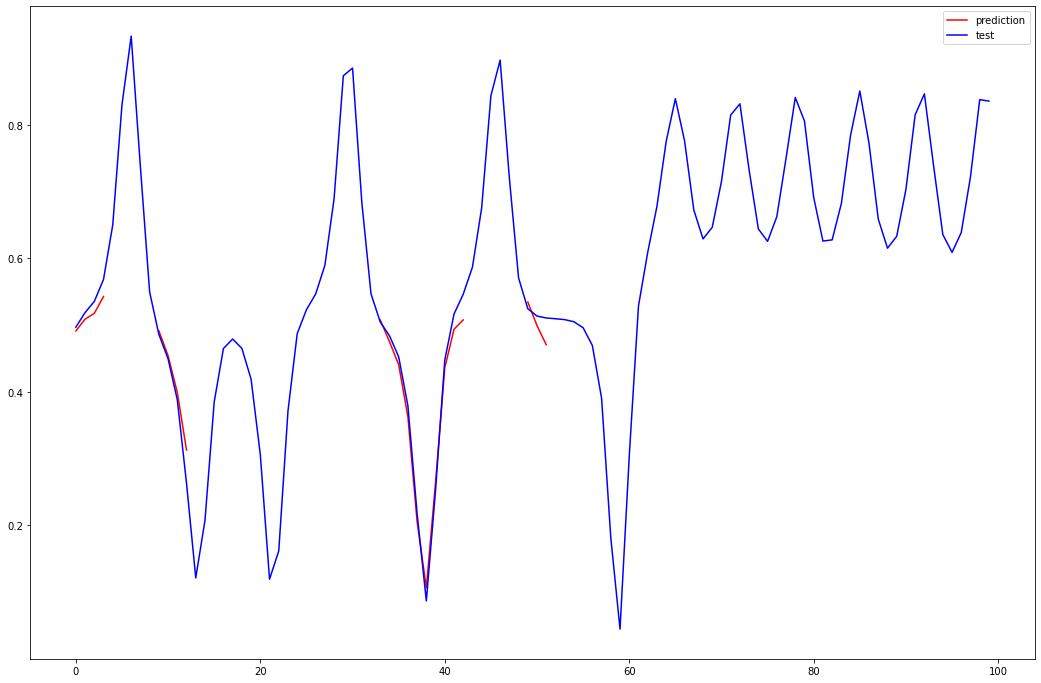

In [189]:
# visualize_predictions(train_data, prediction_i, test_data, h, bad_i)
# for i in range(len(bad_i)):
#     if bad_i[i]:
    #         prediction_i[i] = float('nan')
visualize_predictions(train_data, prediction_i, test_data, h, bad_i)
# visualize_predictions(train_data, skip_non_predictable(prediction_i, bad_i), test_data, h, bad_i)

In [198]:
print(bad_i[-h:])

[0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [200]:
prediction_i, bad_i, possible_i = iterate_prediction(prediction_i, bad_i, 1, train_data, Daemon(mode="simple_d_q", is_pred=False), IdealDeamon(test_data, 0.1), h, L=4, eps=0.009, return_possible_values=True)
# visualize_predictions(train_data, prediction, test_data, h, bad)

[0.49120229 1.        ] 0 0.4925605111312801
[0.5088964 1.       ] 0 0.5091333578884393
[0.51761159 1.        ] 0 0.5206175310593872
[0.54282949 1.        ] 0 0.541111126329359
[0. 1.] 1 0.5843478617200603
[0. 1.] 1 None
[0.91574793 1.        ] 0 0.8855651938122243
[0. 1.] 1 None
[0. 1.] 1 0.6440676808946305
[0.49145366 1.        ] 0 0.5000625381207333
[0.45408836 1.        ] 0 0.452995109308183
[0.39903895 1.        ] 0 0.39910147902909315
[0.3128216 1.       ] 0 0.3114159073079257
[0. 1.] 1 0.21228387884432245
[0.17225818 1.        ] 0 0.17170926178090717
[0. 1.] 1 0.297293787675291
[0. 1.] 1 0.38897699207352987
[0. 1.] 1 0.42273606363991173
[0. 1.] 1 0.3889222980395139
[0. 1.] 1 0.32979555656660786
[0. 1.] 1 None
[0.16924981 1.        ] 0 None
[0. 1.] 1 None
[0.39975434 1.        ] 0 None
[0. 1.] 1 0.41046950668576054
[0. 1.] 1 None
[0. 1.] 1 None
[0. 1.] 1 None
[0. 1.] 1 None
[0. 1.] 1 None
[0.92908748 1.        ] 0 0.8631092133694034
[0. 1.] 1 None
[0. 1.] 1 None
[0.50780803 1.   

In [201]:
print(bad_i[-h:])

[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


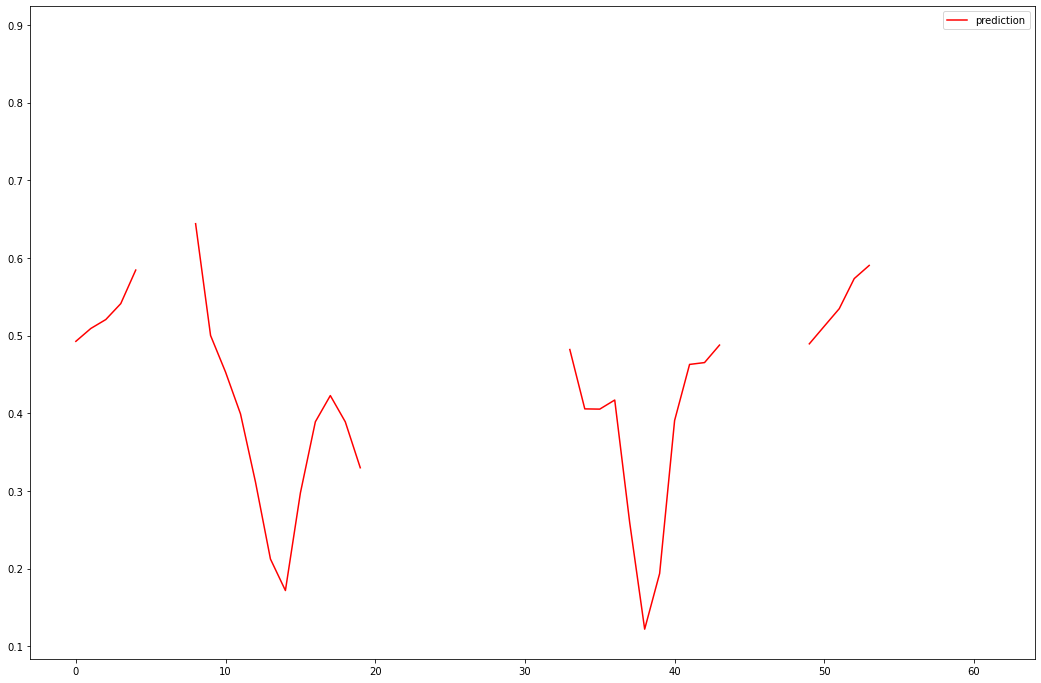

In [202]:
# visualize_predictions(train_data, prediction_i, test_data, h, bad_i)
# for i in range(len(bad_i)):
#     if bad_i[i]:
#         prediction_i[i] = float('nan')
visualize_predictions(train_data, prediction_i, test_data, h, bad_i)

Self Healing Algorithm

In [167]:
ITERATIONS=5

In [168]:
h = 100
print(len(train_data))
prediction_i, bad_i, possible_i = base_prediction_ideal(train_data, Daemon(mode="simple_d_q", is_pred=False), IdealDeamon(test_data, 0.05), h, L=4, eps=0.009, return_possible_values=True)

10000


/home/mrplotva/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mrplotva/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


23002700


40865637


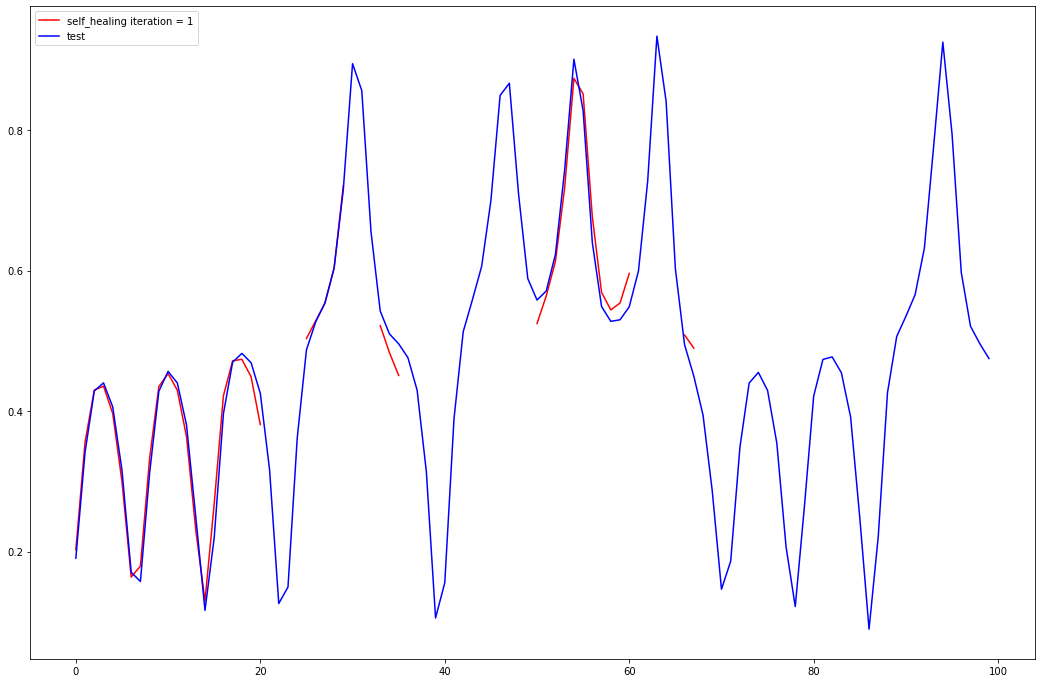

66558648


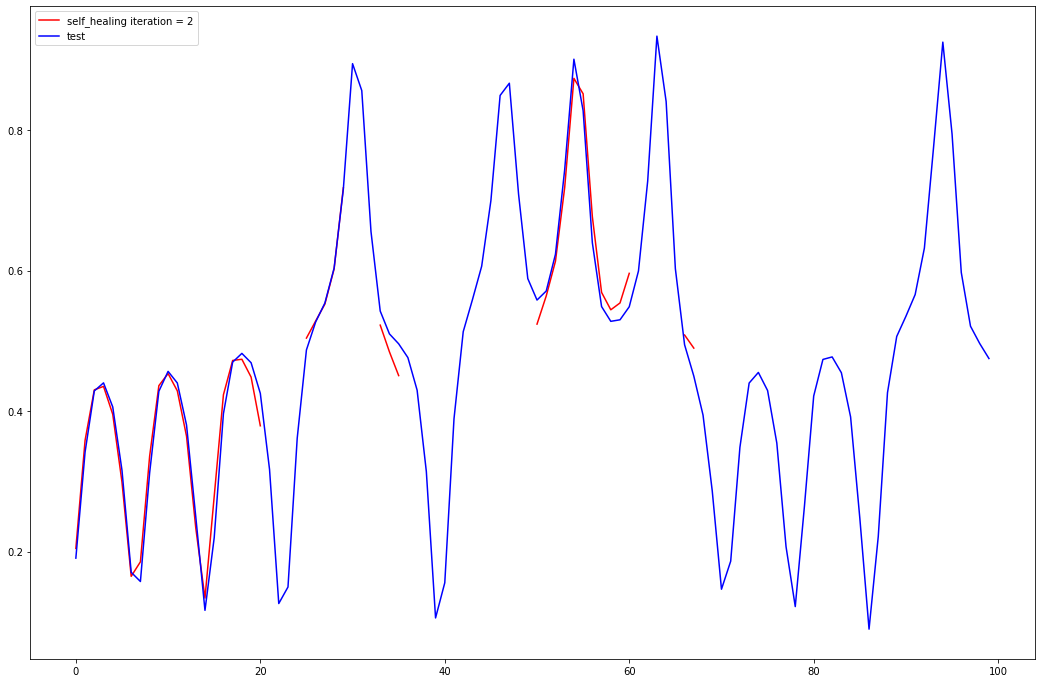

KeyboardInterrupt: 

In [138]:
iter_predictions = [prediction_i]
iter_bad = [bad_i]
for iter in range(ITERATIONS):
    next_pred, next_bad, next_possible = iterate_prediction(iter_predictions[-1], iter_bad[-1], 1, train_data, Daemon(mode="simple_d_q", is_pred=False), IdealDeamon(test_data, 0.1), h, L=4, eps=0.009, return_possible_values=True)

    visualize_predictions(train_data, next_pred, test_data, h, next_bad, label=f"self_healing iteration = {iter + 1}")
    iter_predictions.append(next_pred)
    iter_bad.append(next_bad)
# visualize_predictions(train_data, prediction, test_data, h, bad)

In [140]:
print(iter_bad[0][-h:])
print(iter_bad[1][-h:])
print(iter_bad[2][-h:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [25]:
# np.save("prediction_hor_100.npy", np.array(prediction[-h:]))
# np.save("pos_val_hor_100.npy", np.array(possible_values[-h:]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

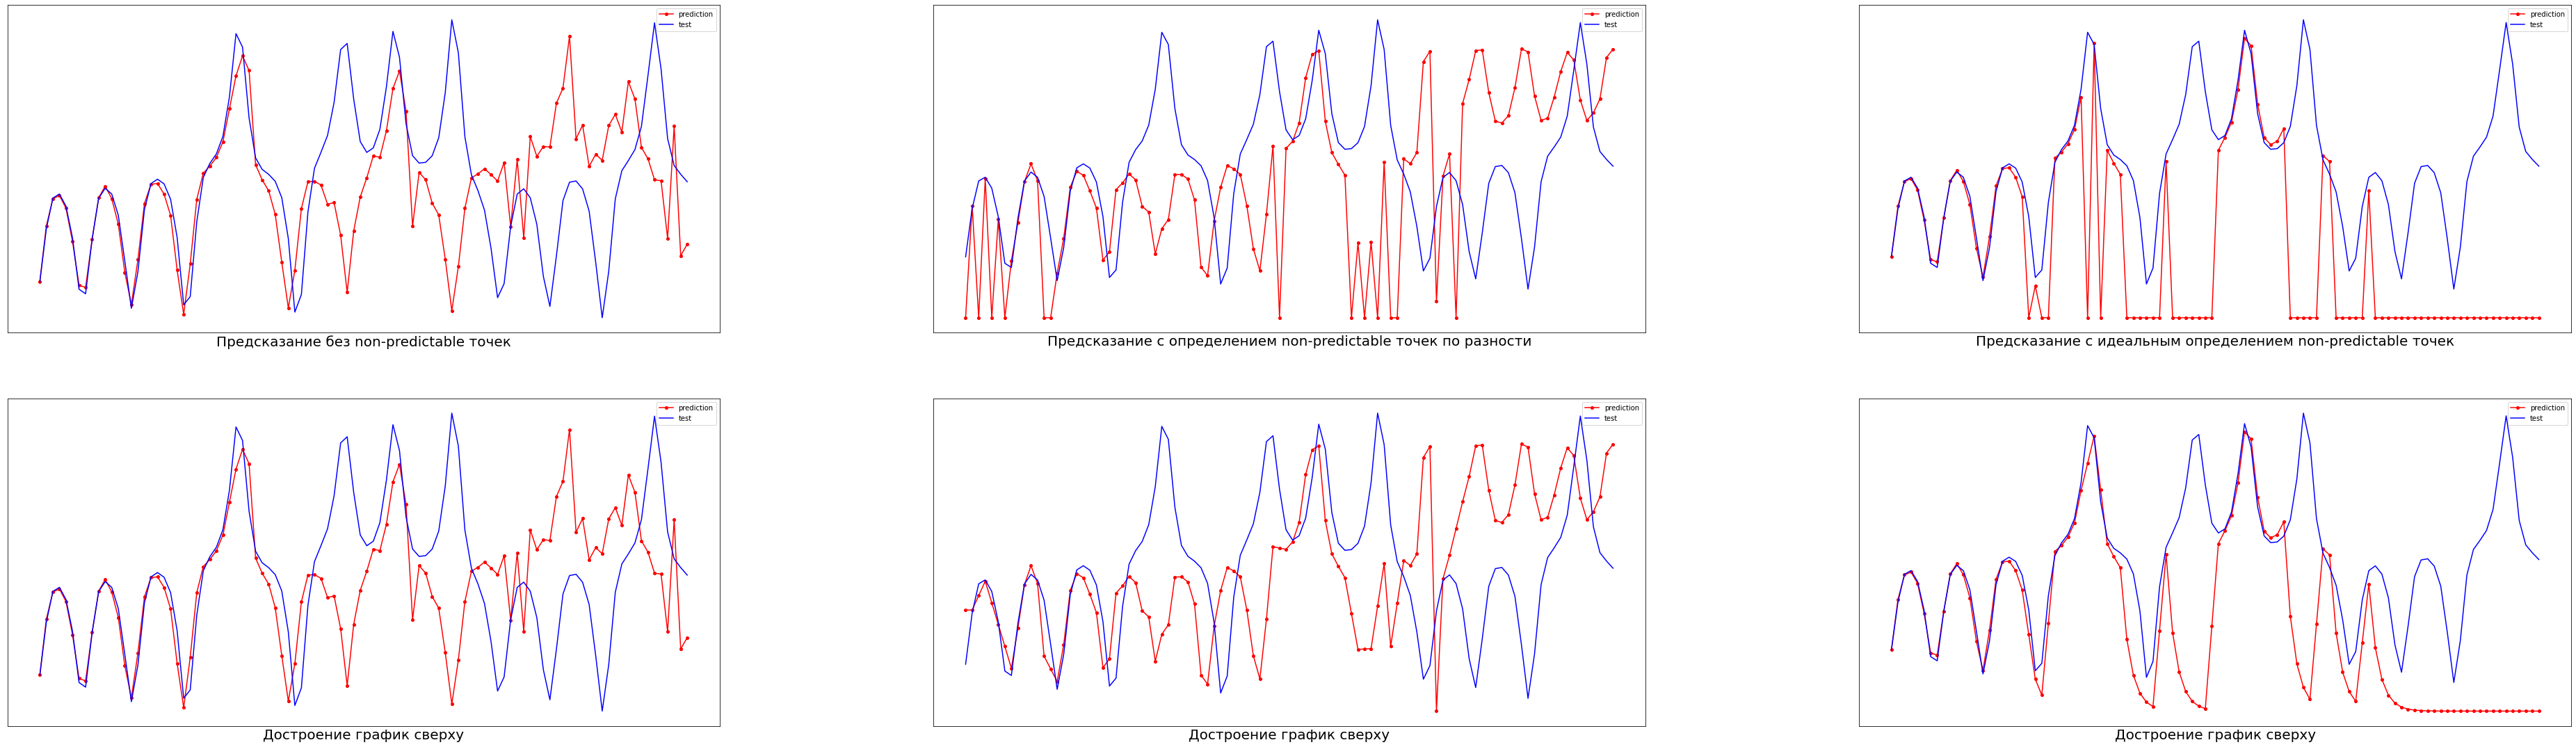

In [87]:
fig, axs = plt.subplots(2, 3, figsize=(64, 18))
plt.setp(axs, xticks=[], yticks=[])
visualize_predictions(train_data, prediction, test_data, h, bad, axs[0, 0])
visualize_predictions(train_data, skip_non_predictable(prediction, bad), test_data, h, bad, axs[1, 0])
visualize_predictions(train_data, prediction_pred, test_data, h, bad_pred, axs[0, 1])
visualize_predictions(train_data, skip_non_predictable(prediction_pred, bad_pred), test_data, h, bad_pred, axs[1, 1])
visualize_predictions(train_data, prediction_i, test_data, h, bad_i, axs[0, 2])
visualize_predictions(train_data, skip_non_predictable(prediction_i, bad_i), test_data, h, bad_i, axs[1, 2])

x_labels = [['Предсказание без non-predictable точек',  
            'Предсказание c определением non-predictable точек по разности', 'Предсказание c идеальным определением non-predictable точек'], ['Достроение график сверху'] * 3]
[axs[j, i].set_xlabel(x_labels[j][i], fontsize=20) for i in range(len(x_labels[0])) for j in range(2)]
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

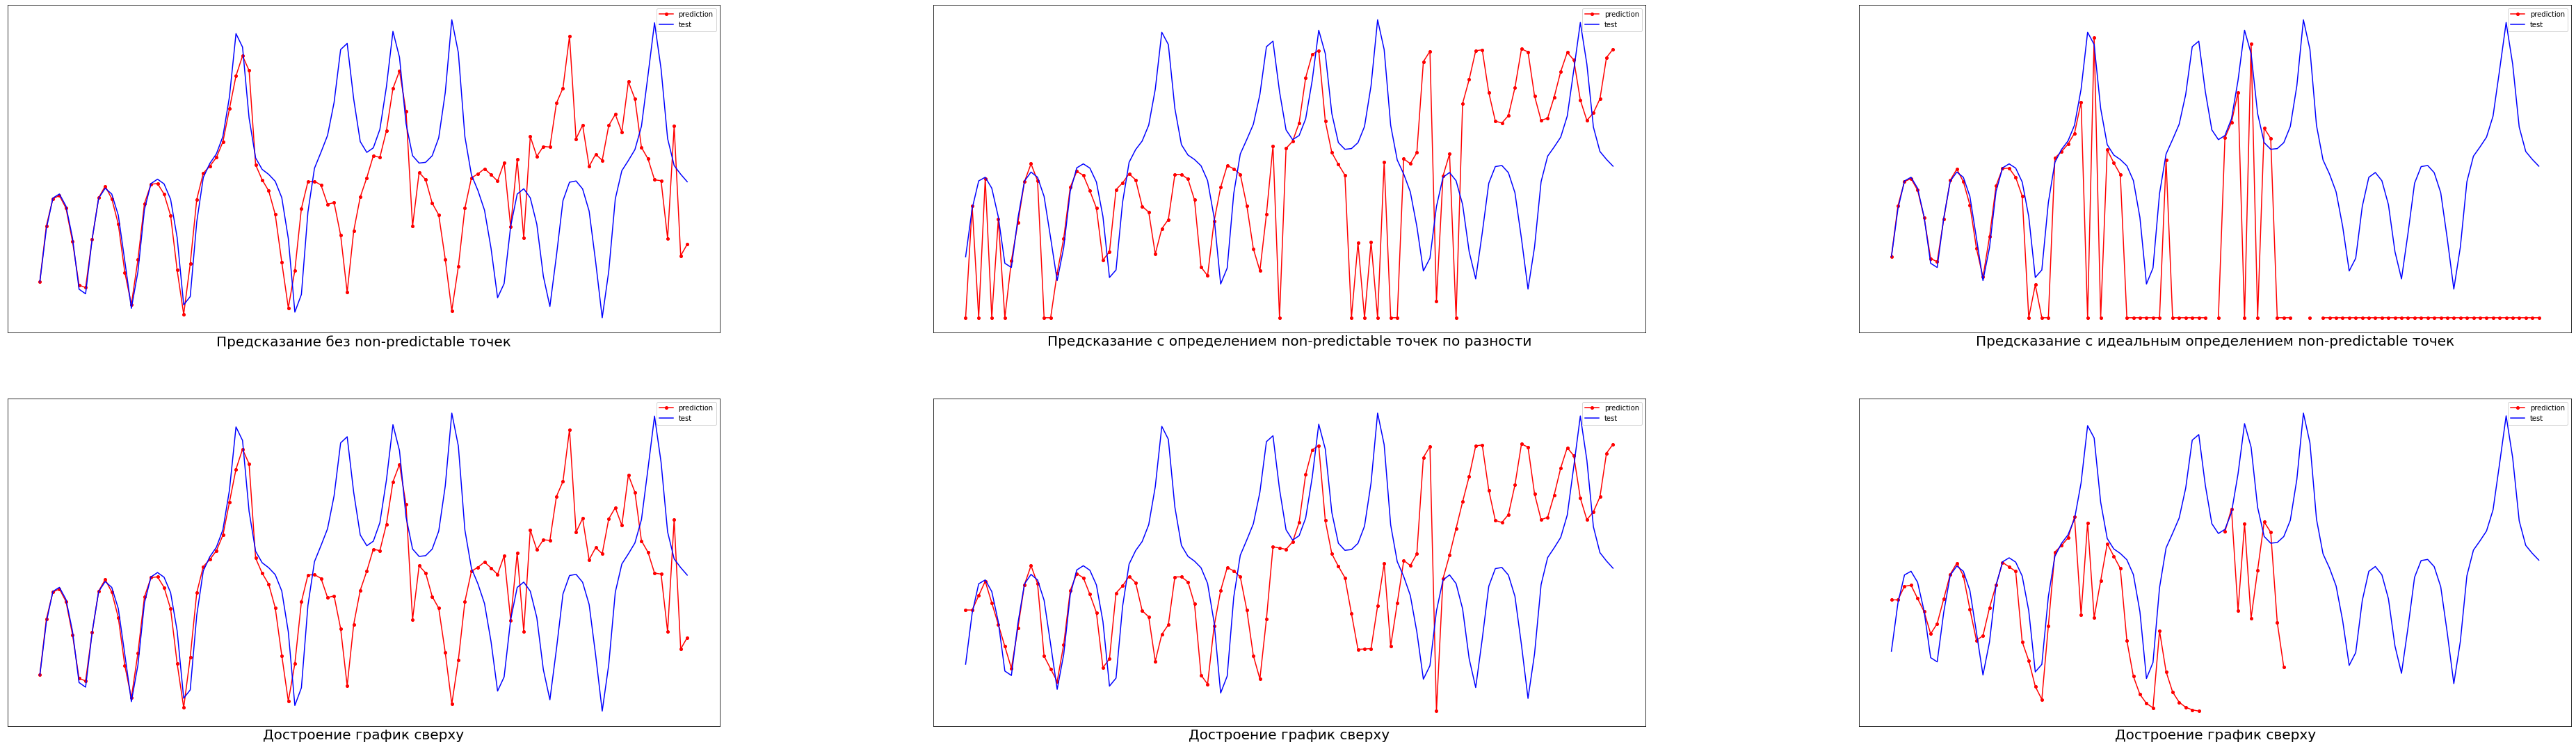

In [62]:
fig, axs = plt.subplots(2, 3, figsize=(64, 18))
plt.setp(axs, xticks=[], yticks=[])
visualize_predictions(train_data, prediction, test_data, h, bad, axs[0, 0])
visualize_predictions(train_data, skip_non_predictable(prediction, bad), test_data, h, bad, axs[1, 0])
visualize_predictions(train_data, prediction_pred, test_data, h, bad_pred, axs[0, 1])
visualize_predictions(train_data, skip_non_predictable(prediction_pred, bad_pred), test_data, h, bad_pred, axs[1, 1])
visualize_predictions(train_data, prediction_i, test_data, h, bad_i, axs[0, 2])
visualize_predictions(train_data, skip_non_predictable(prediction_i, bad_i), test_data, h, bad_i, axs[1, 2])

x_labels = [['Предсказание без non-predictable точек',  
            'Предсказание c определением non-predictable точек по разности', 'Предсказание c идеальным определением non-predictable точек'], ['Достроение график сверху'] * 3]
[axs[j, i].set_xlabel(x_labels[j][i], fontsize=20) for i in range(len(x_labels[0])) for j in range(2)]
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

In [28]:
# bad = [0 for i in range(h)]
# eps = 0.05
# for i in range(h):
#     if abs(prediction[-h + i][0] - test_data[i]) >= eps:
#         bad[i] = 1

0.1907839601103979   0.1924206222700053
0.1907839601103979   0.1924206222700053
0.34174857403388154   0.3498251347662792
0.1907839601103979   0.1924206222700053
0.34174857403388154   0.3498251347662792
0.4286767977107237   0.42685026855133834
0.1907839601103979   0.1924206222700053
0.34174857403388154   0.3498251347662792
0.4286767977107237   0.42685026855133834
0.4401506181918288   0.43566083050228765
0.1907839601103979   0.1924206222700053
0.34174857403388154   0.3498251347662792
0.4286767977107237   0.42685026855133834
0.4401506181918288   0.43566083050228765
0.40586470499280114   0.399854429413329
0.1907839601103979   0.1924206222700053
0.34174857403388154   0.3498251347662792
0.4286767977107237   0.42685026855133834
0.4401506181918288   0.43566083050228765
0.40586470499280114   0.399854429413329
0.31587754047930133   0.30571022371357787
0.1907839601103979   0.1924206222700053
0.34174857403388154   0.3498251347662792
0.4286767977107237   0.42685026855133834
0.4401506181918288   0.4

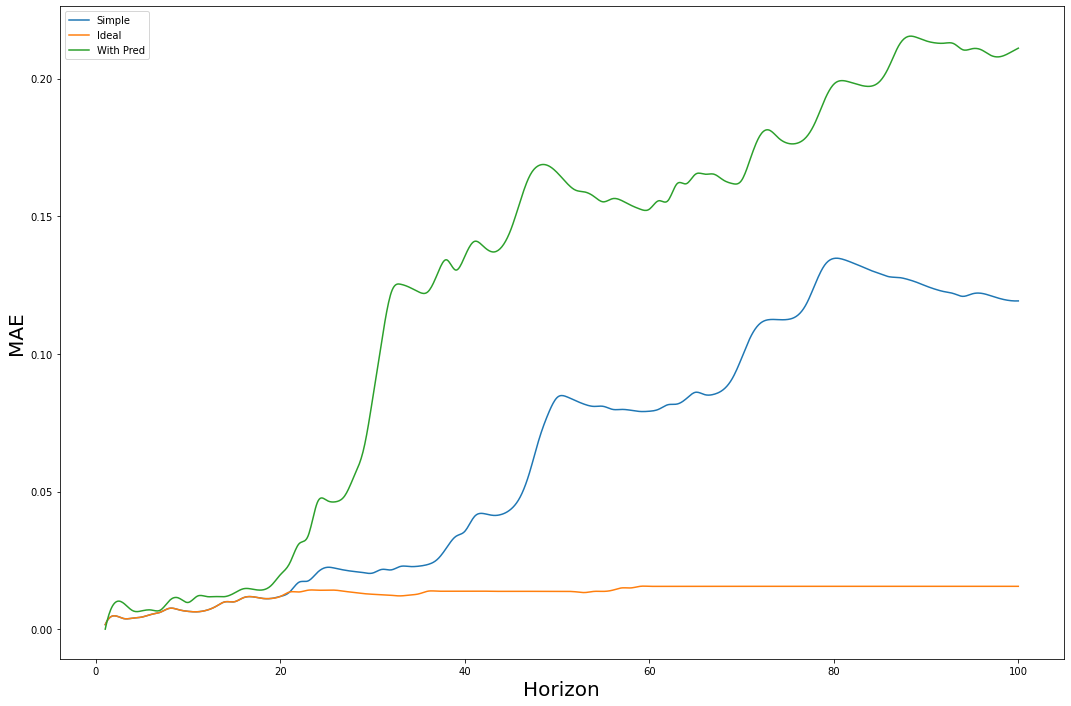

In [29]:
def get_mae(preds, actual, bad, h, pref):
    mae = 0
    cnt = 0
    for i in range(pref):
        if bad[i]:
            continue
        print(actual[i], " ", preds[i][0])
        mae += abs(actual[i] - preds[i][0])
        cnt += 1
    if cnt == 0:
        return 0
    return mae / cnt


def get_mse(preds, actual, bad, h, pref):
    mae = 0
    cnt = 0
    for i in range(pref):
        if bad[i]:
            continue
        mae += abs(actual[i] - preds[i][0]) ** 2
        cnt += 1
    if cnt == 0:
        return 0
    return mae / cnt

def get_rmse(preds, actual, bad, h, pref):
    return get_mse(preds, actual, bad, h, pref) ** 0.5

def get_amount_of_predictable_pts(preds, actual, bad, h, pref):
    return sum(bad[:pref]) / pref * 100.0

def smooth_plot(x, y, plt):
    xnew = np.linspace(x.min(), x.max(), 1000) 

    spl = make_interp_spline(x, np.array(y), k=3)
    power_smooth = spl(xnew)
    line, = plt.plot(xnew, power_smooth)
    return line

# print(f"MAE {get_mae(prediction, train_data, bad, h)}")
# print(f"MSE {get_mae(prediction, train_data, bad, h)}")

# Cutting
prediction_i = prediction_i[-h:]
bad_i = bad_i[-h:]
prediction = prediction[-h:]
bad = bad[-h:]
prediction_pred = prediction_pred[-h:]
bad_pred = bad_pred[-h:]

mae_val_i = [get_mae(prediction_i, test_data, bad_i, h, i) for i in range(1, h + 1)]
mae_val = [get_mae(prediction, test_data, bad, h, i) for i in range(1, h + 1)]
mae_val_pred = [get_mae(prediction_pred, test_data, bad_pred, h, i) for i in range(1, h + 1)]
'''

plt.figure(figsize=(18, 12))

xnew = np.linspace(1, h + 1, 300)

spl = make_interp_spline(np.array(range(1, h + 1)), np.array(mae_val), k=3)
power_smooth = spl(xnew)
'''
plt.figure(figsize=(18, 12))
smooth_plot(np.array(range(1, h + 1)), np.array(mae_val), plt).set_label("Simple")
smooth_plot(np.array(range(1, h + 1)), np.array(mae_val_i), plt).set_label("Ideal")
smooth_plot(np.array(range(1, h + 1)), np.array(mae_val_pred), plt).set_label("With Pred")
plt.legend()
plt.xlabel("Horizon", size=20)
plt.ylabel("MAE", size=20)
plt.show()
# print(f"MAE {get_mae(prediction, train_data, bad, h)}")

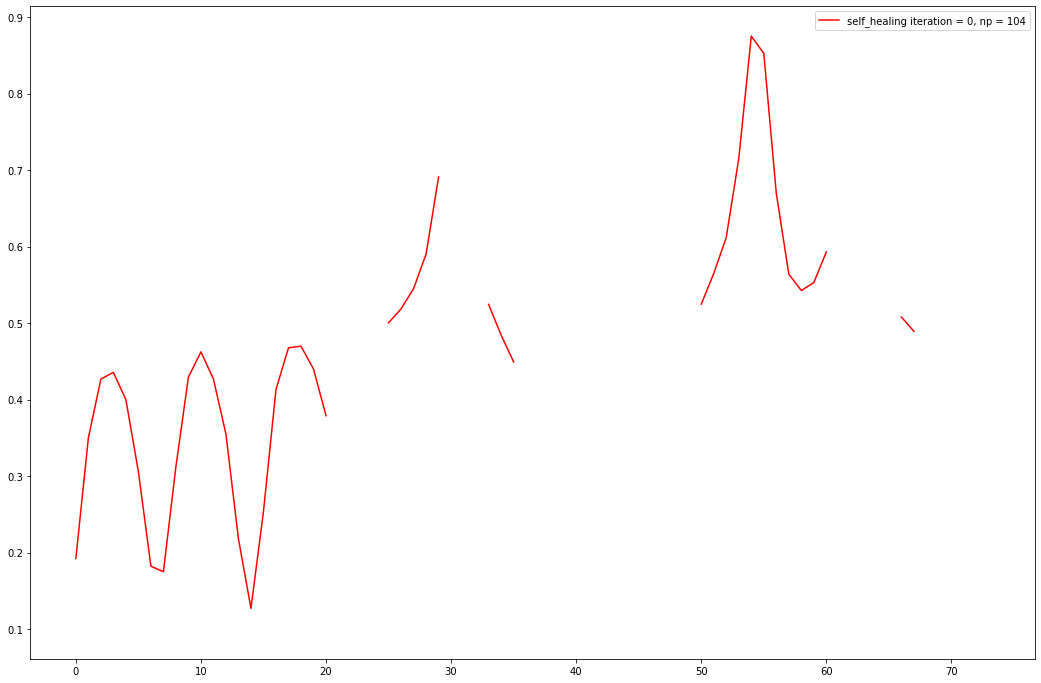

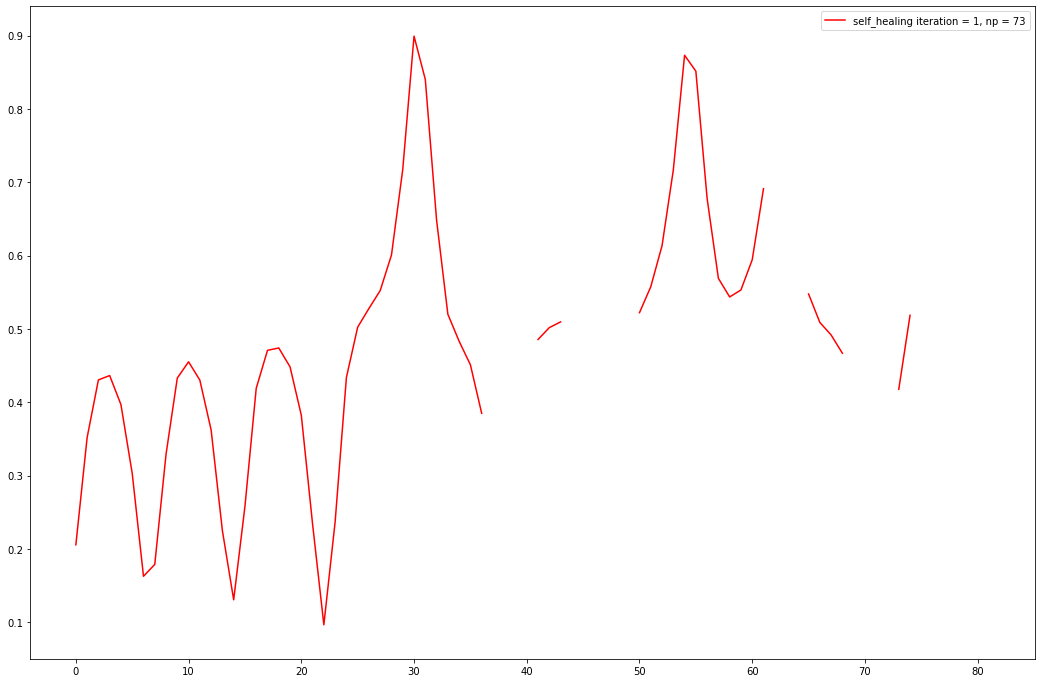

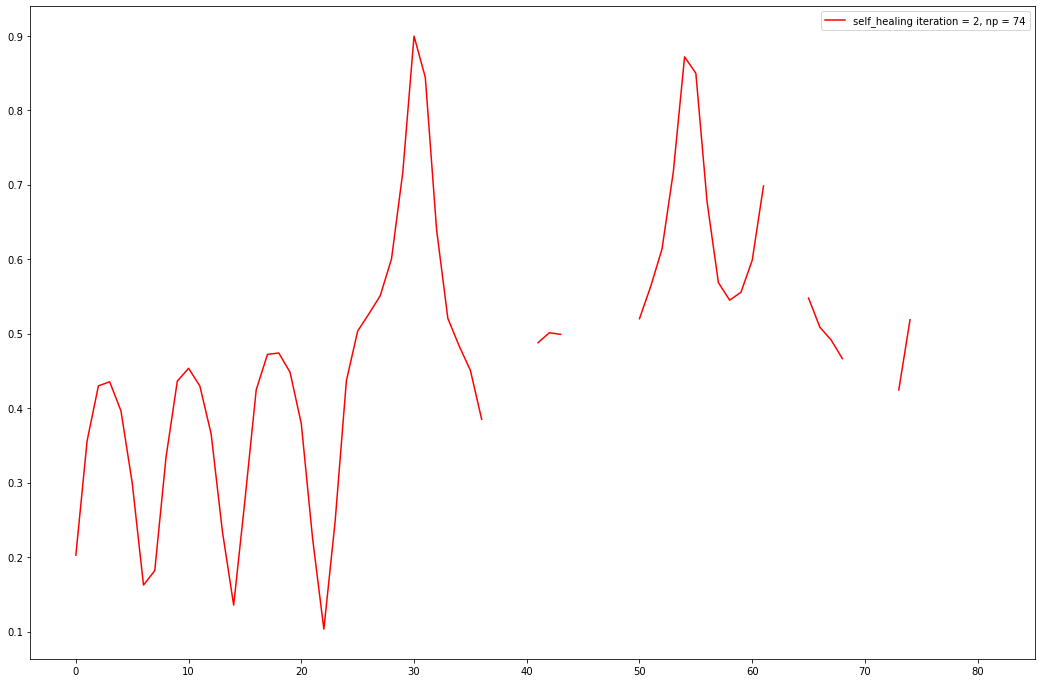

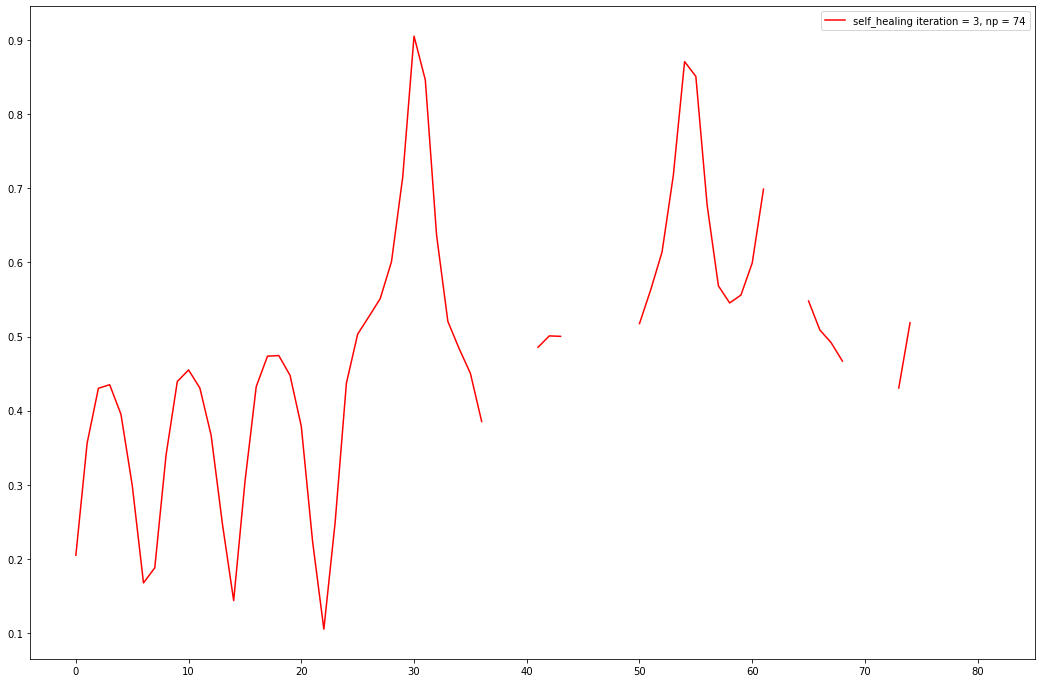

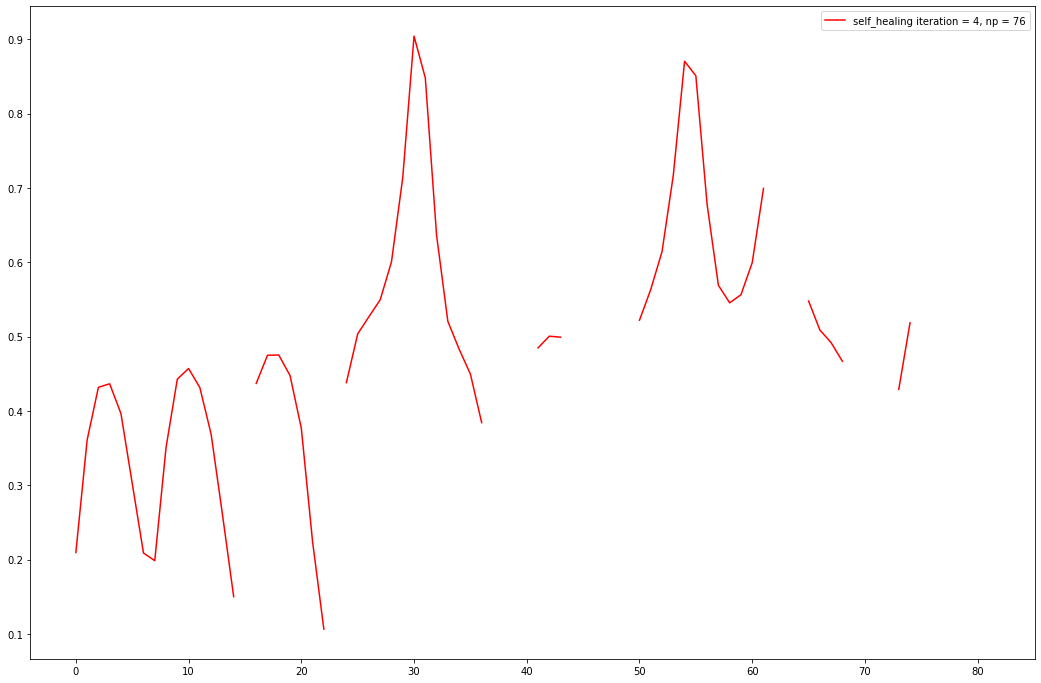

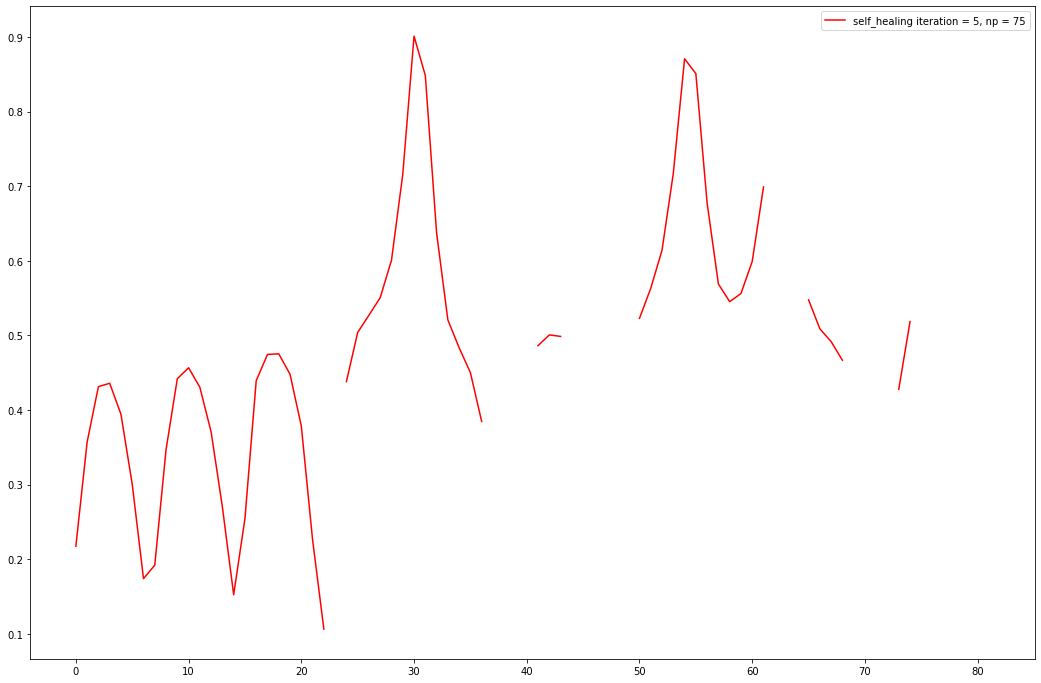

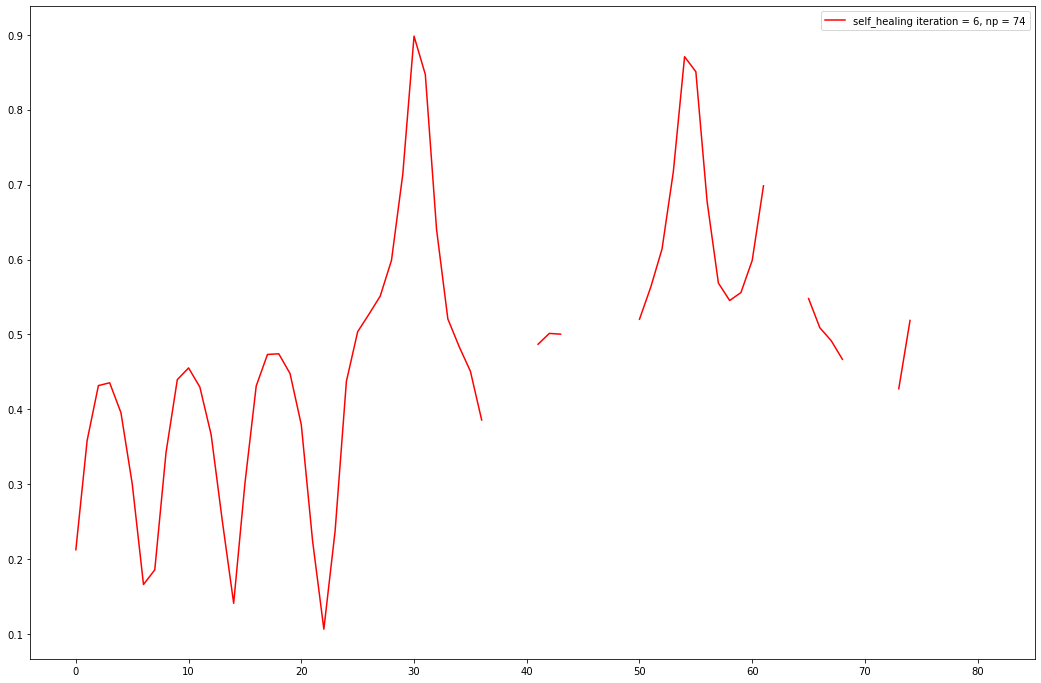

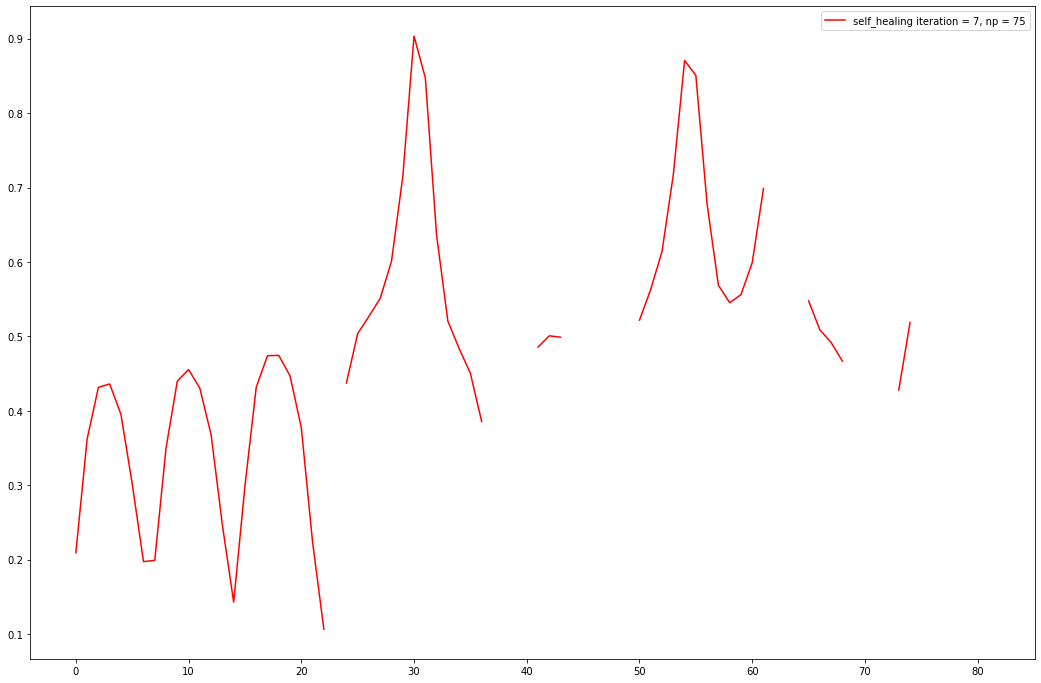

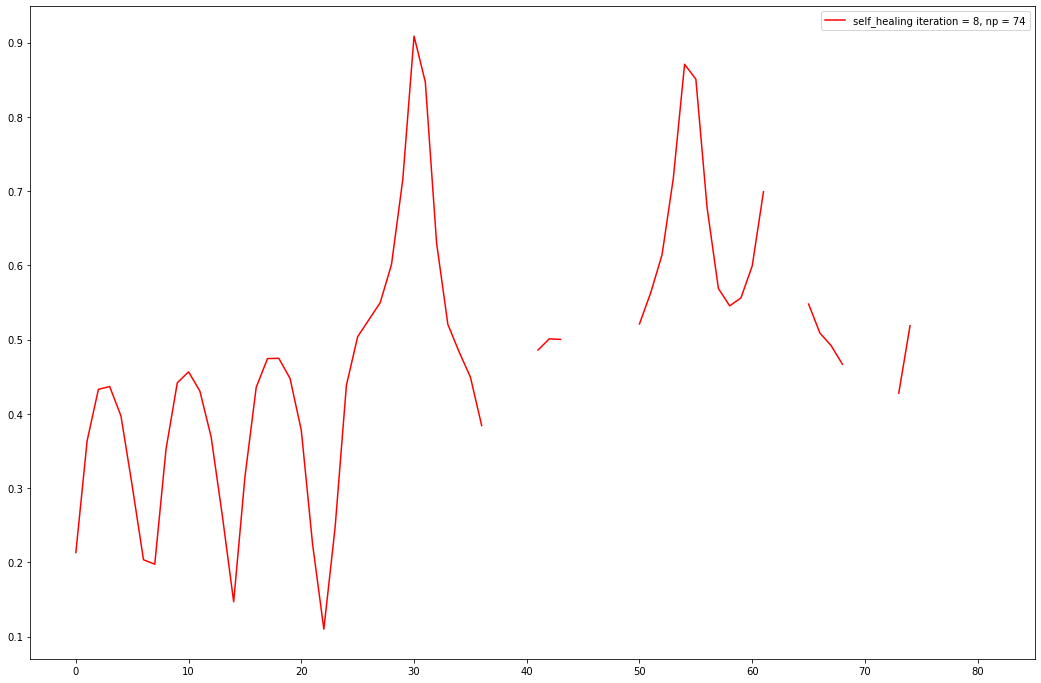

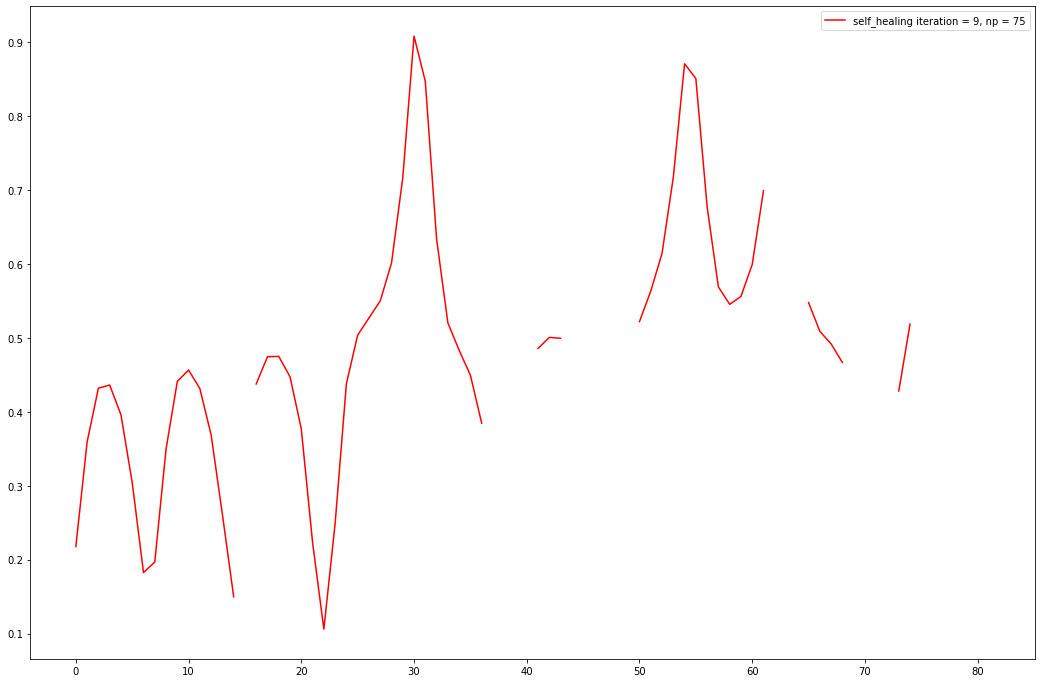

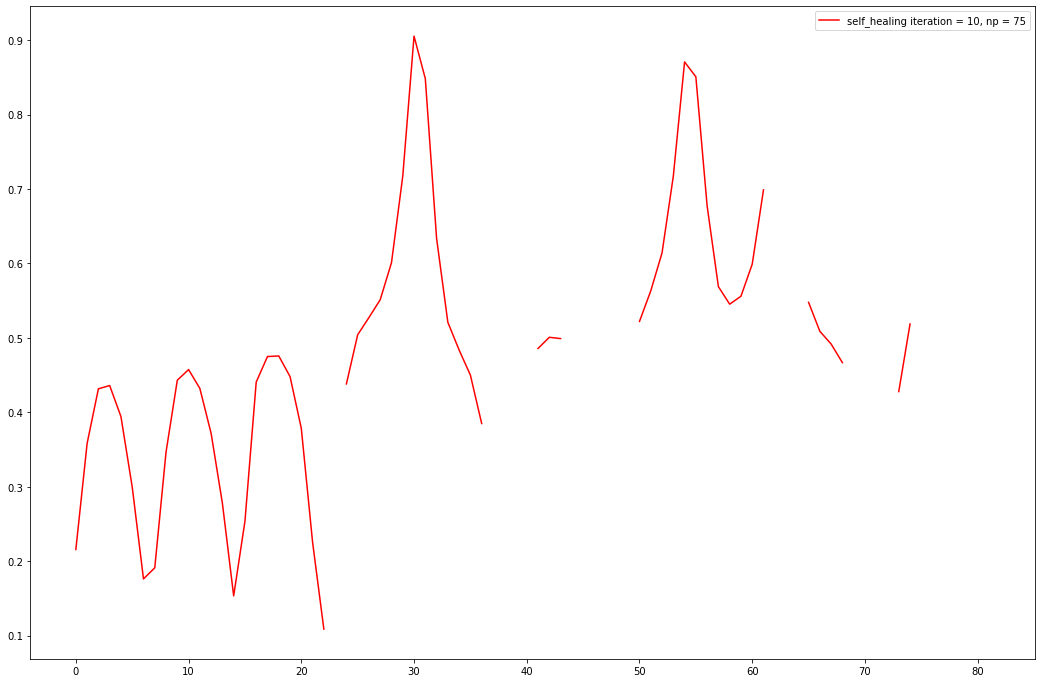

In [210]:
for i in range(11):
    pred_a = np.load(f"self_healing/pred_iter={i}.npy", allow_pickle=True)
    bad_b = np.load(f"self_healing/bad_iter={i}.npy", allow_pickle=True)
    visualize_predictions(train_data, pred_a, test_data, 150, bad_b, label=f"self_healing iteration = {i}, np = {sum(bad_b[-150:])}")

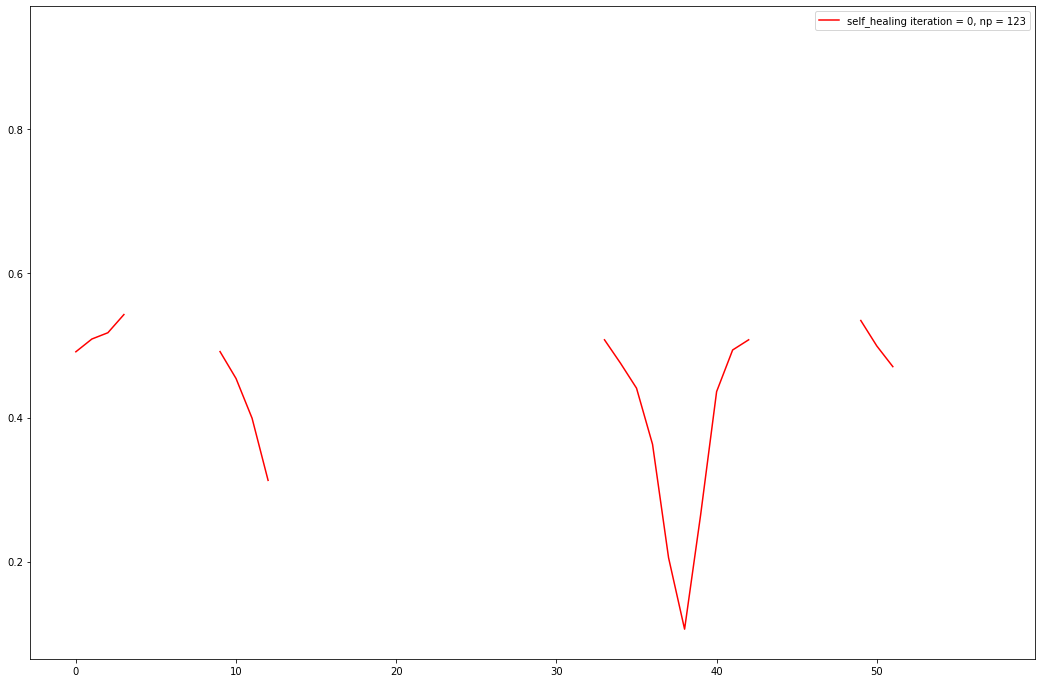

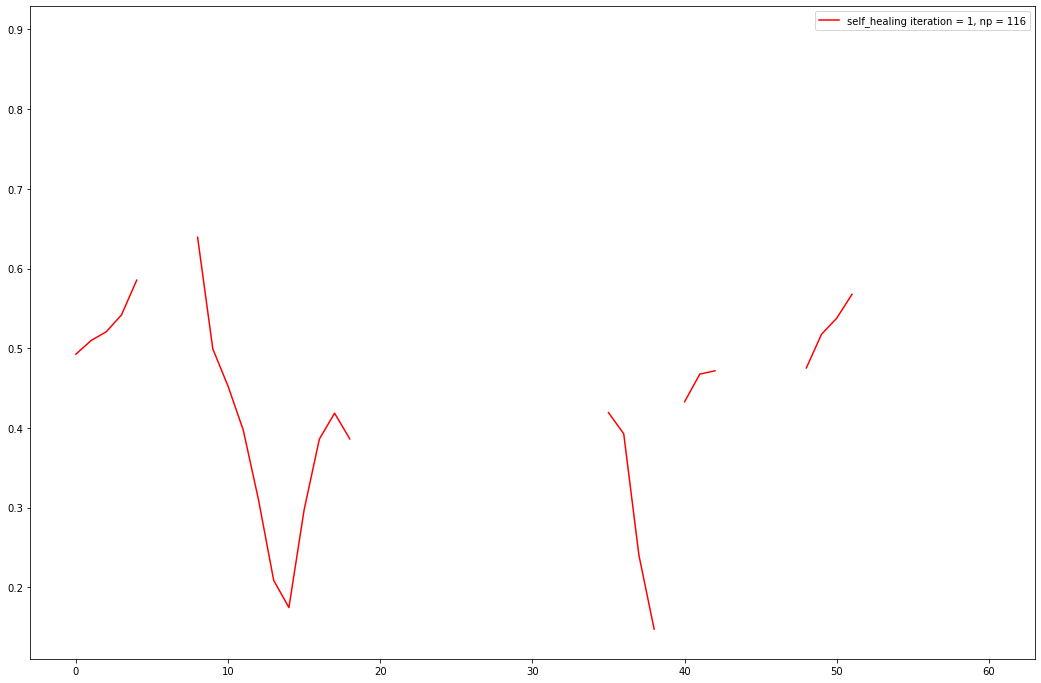

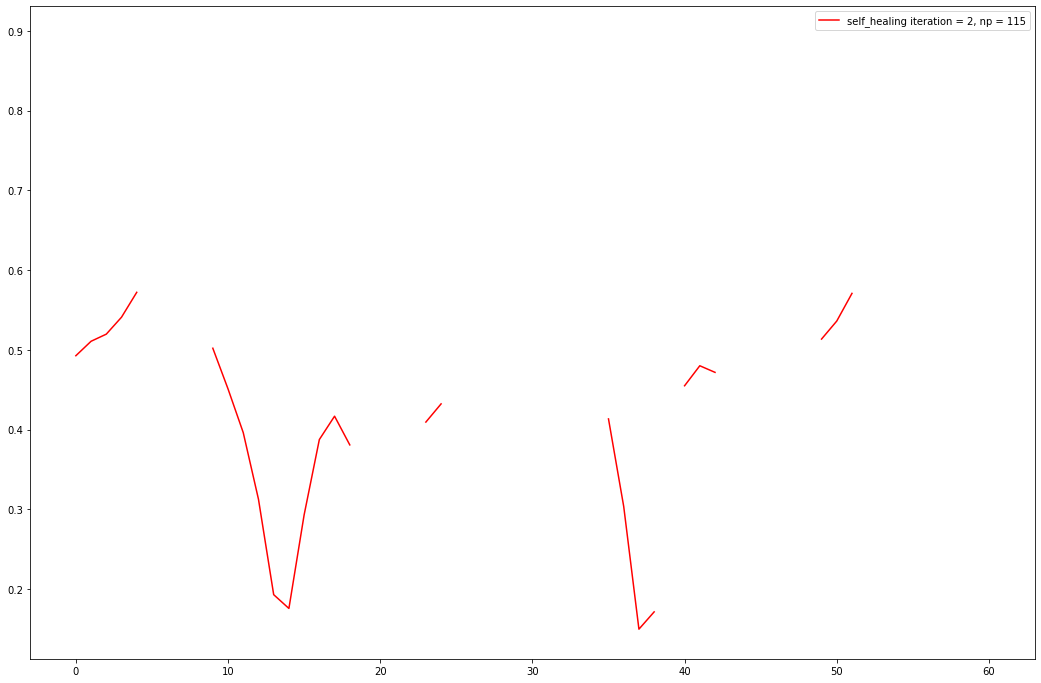

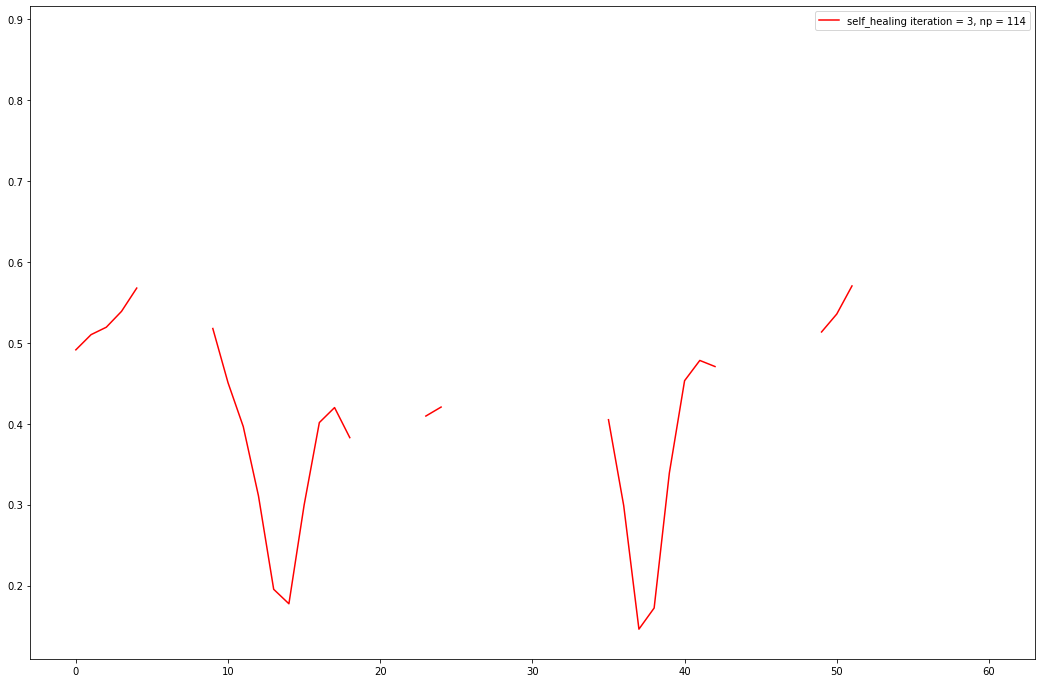

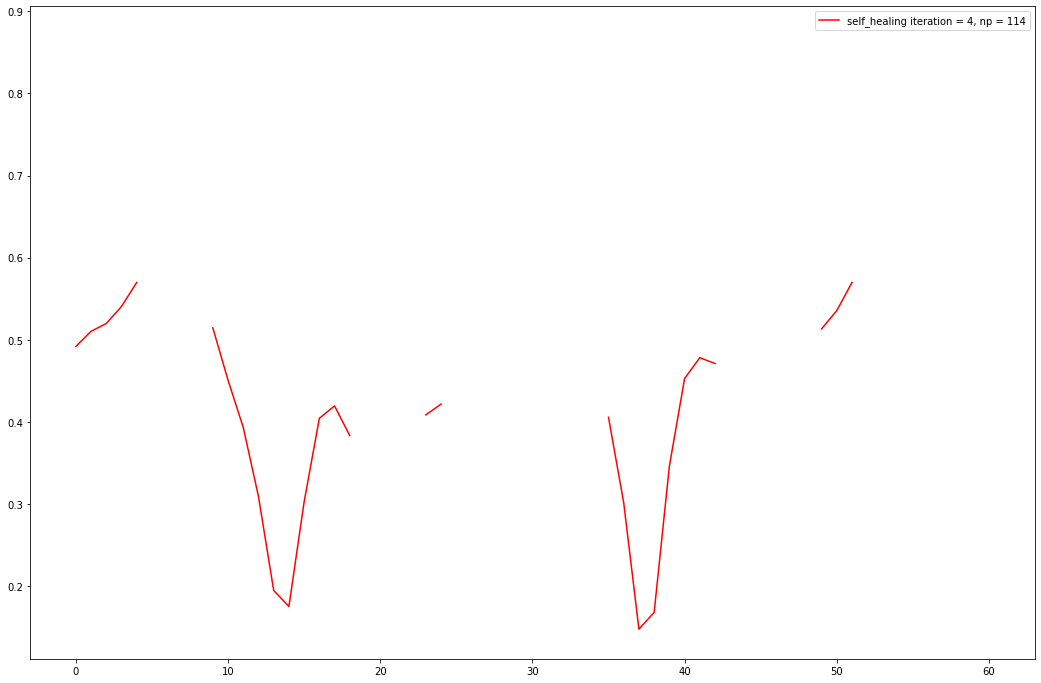

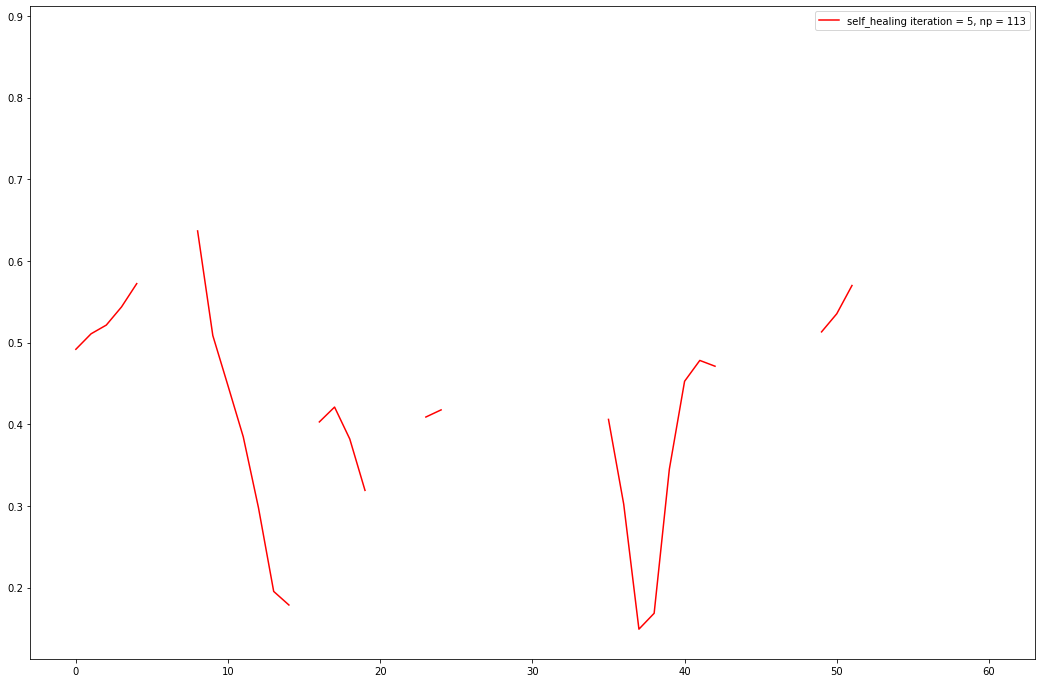

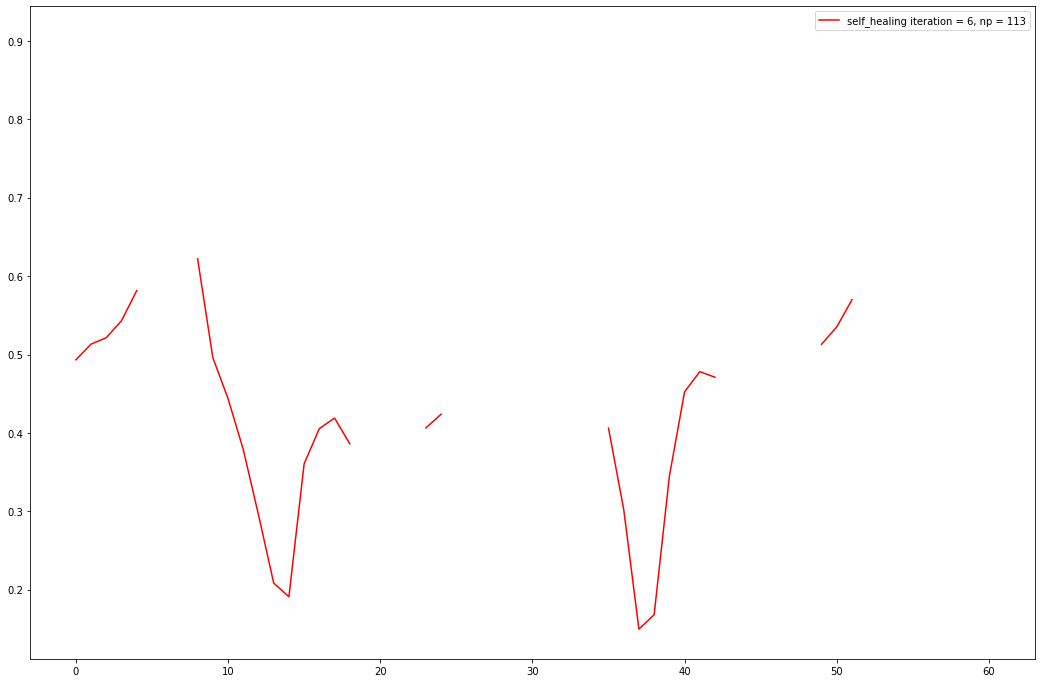

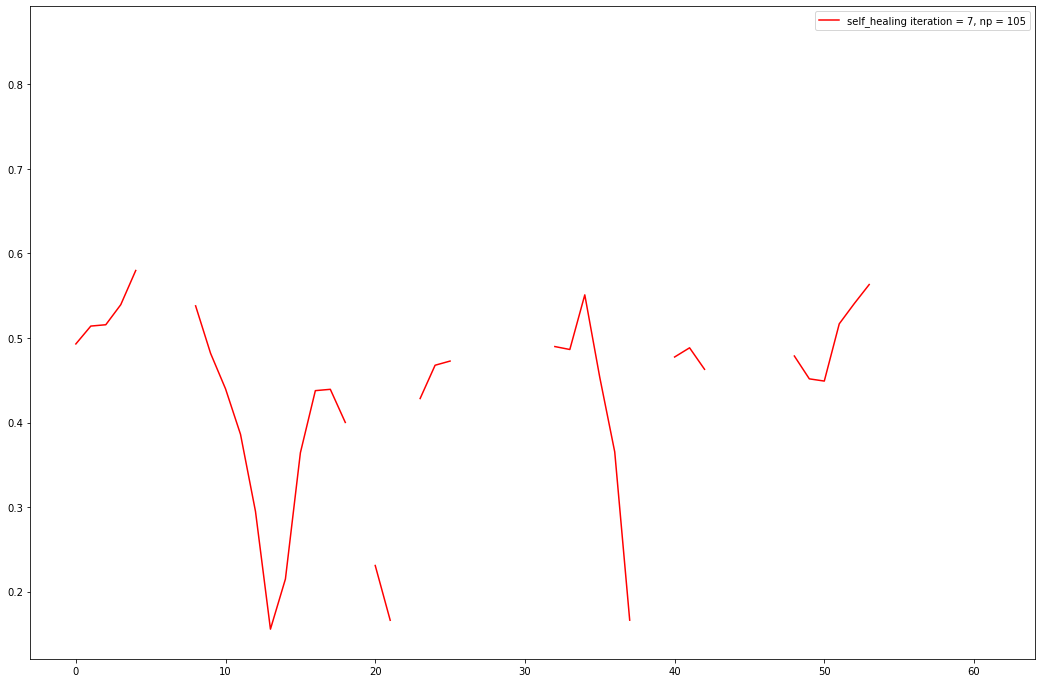

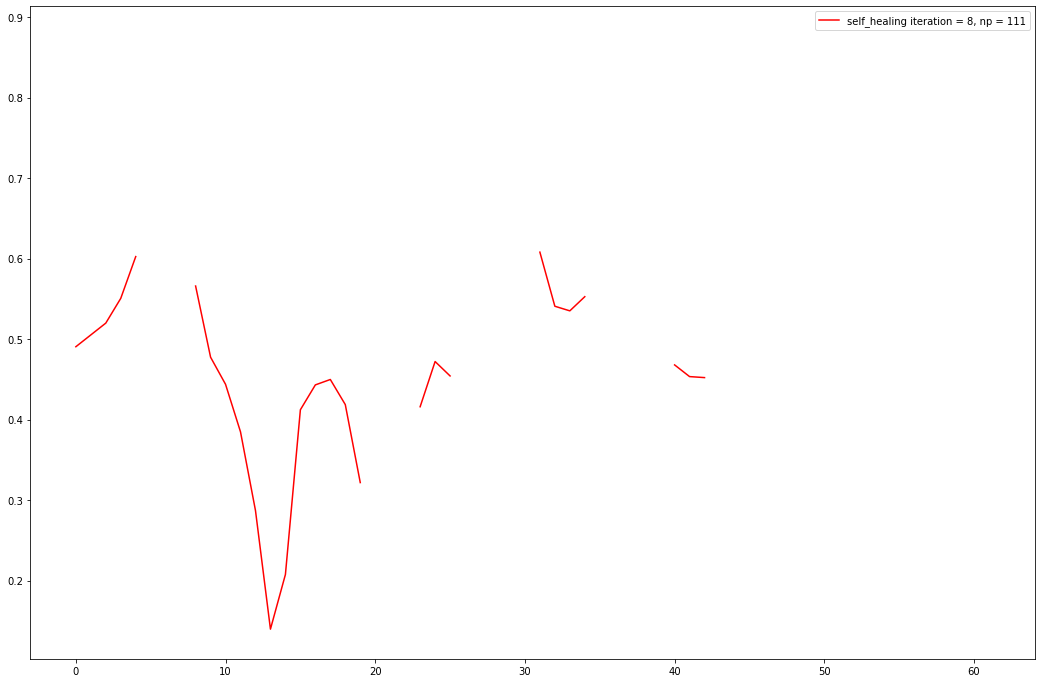

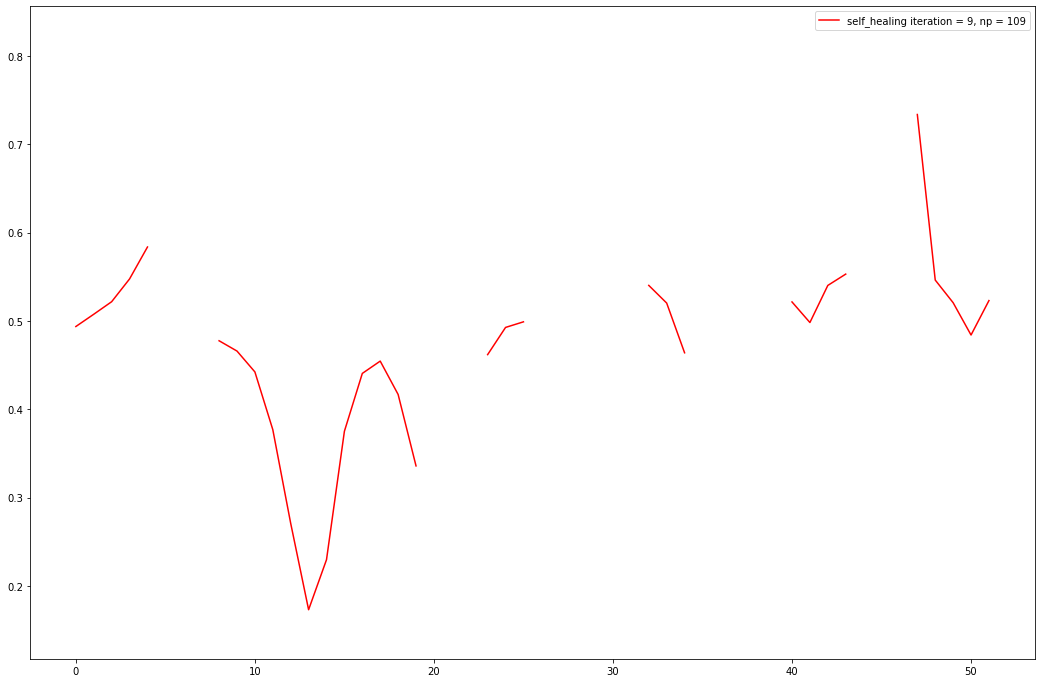

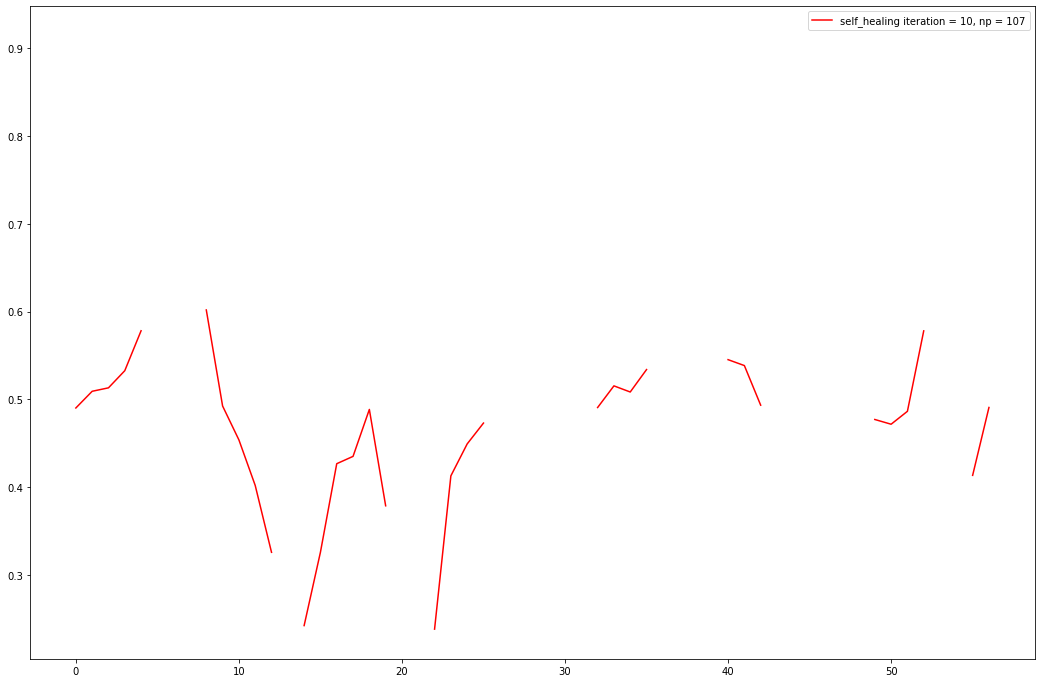

In [211]:
for i in range(11):
    pred_a = np.load(f"self_healing_15000/pred_iter={i}.npy", allow_pickle=True)
    bad_b = np.load(f"self_healing_15000/bad_iter={i}.npy", allow_pickle=True)
    visualize_predictions(train_data, pred_a, test_data, 150, bad_b, label=f"self_healing iteration = {i}, np = {sum(bad_b[-150:])}")

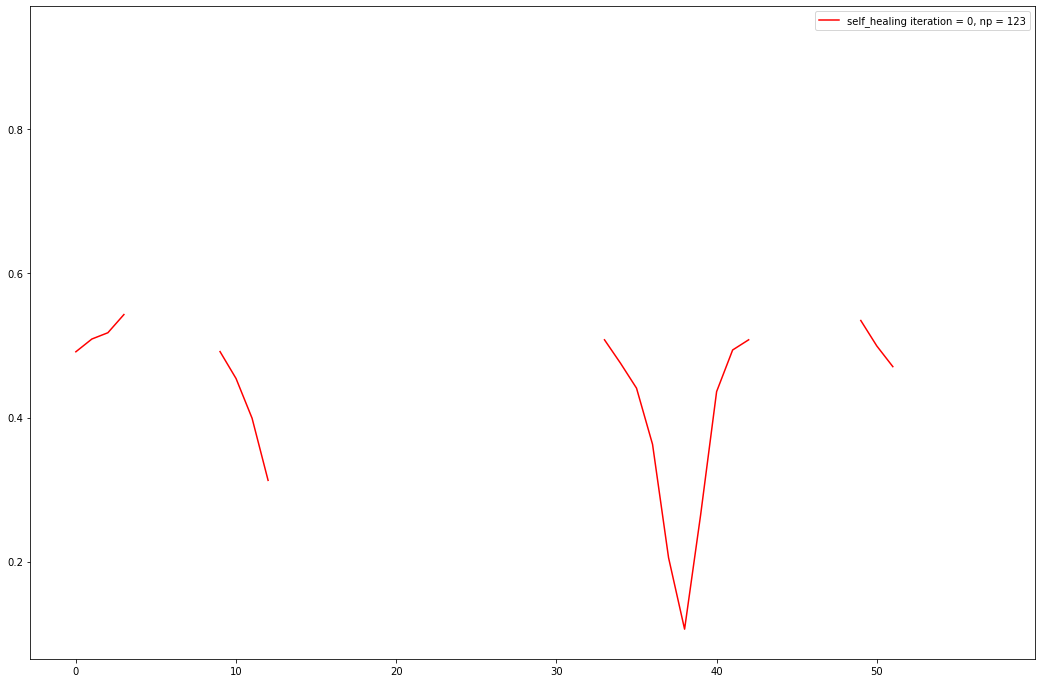

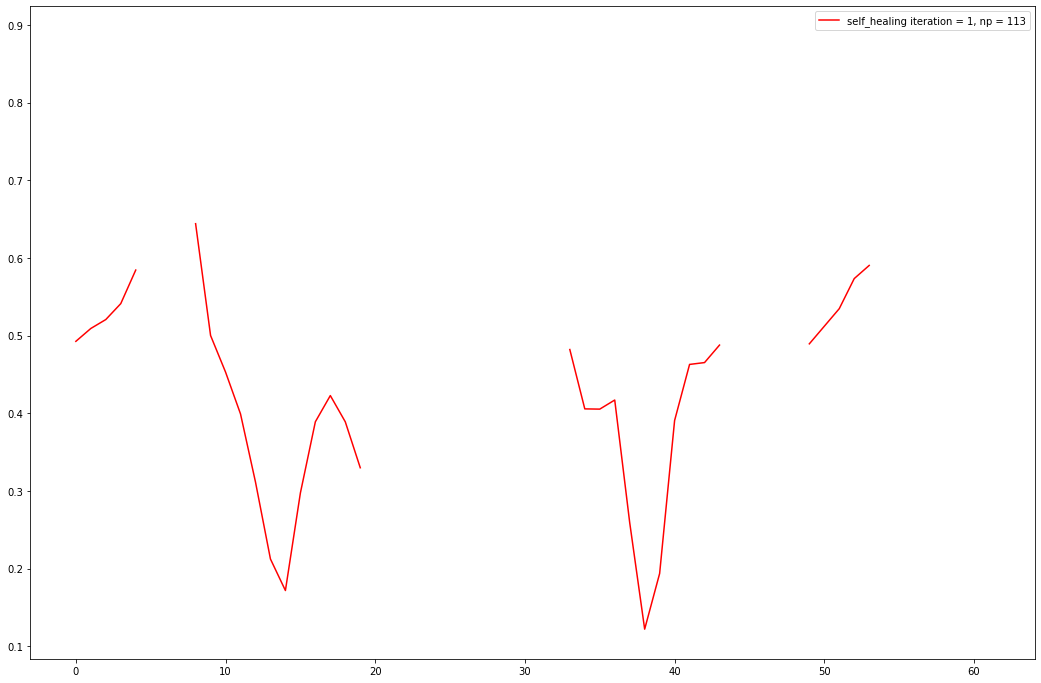

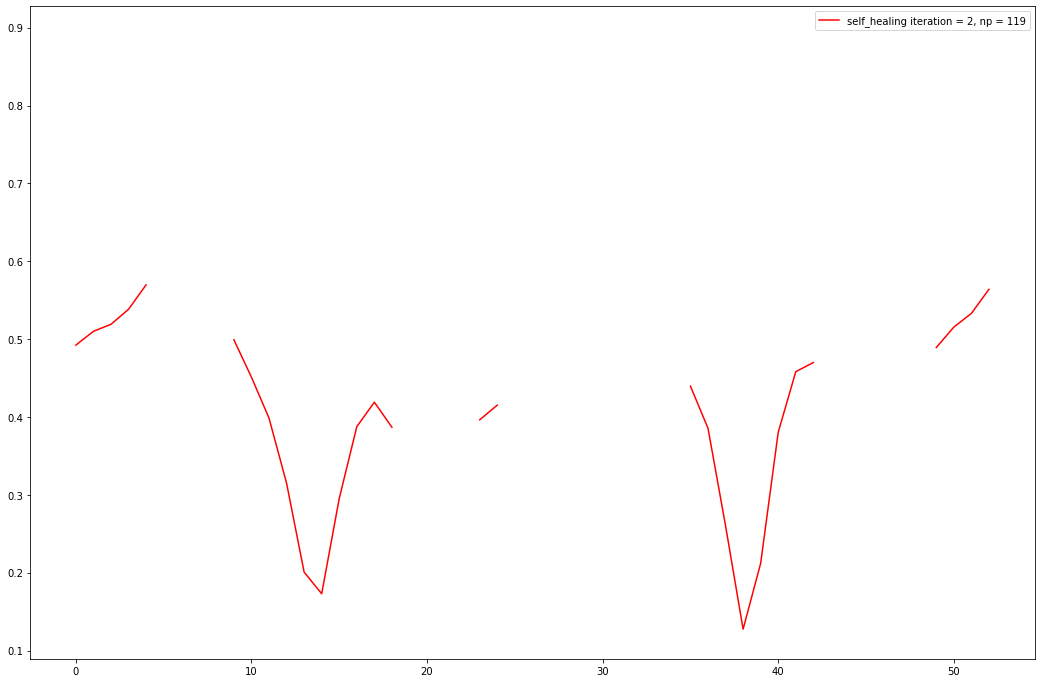

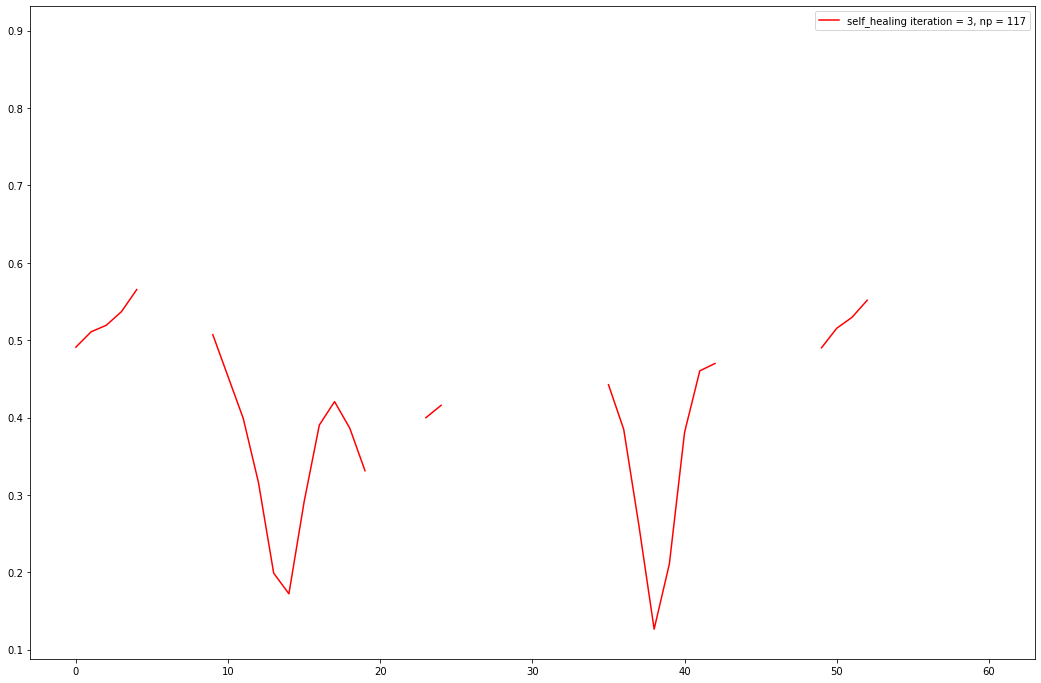

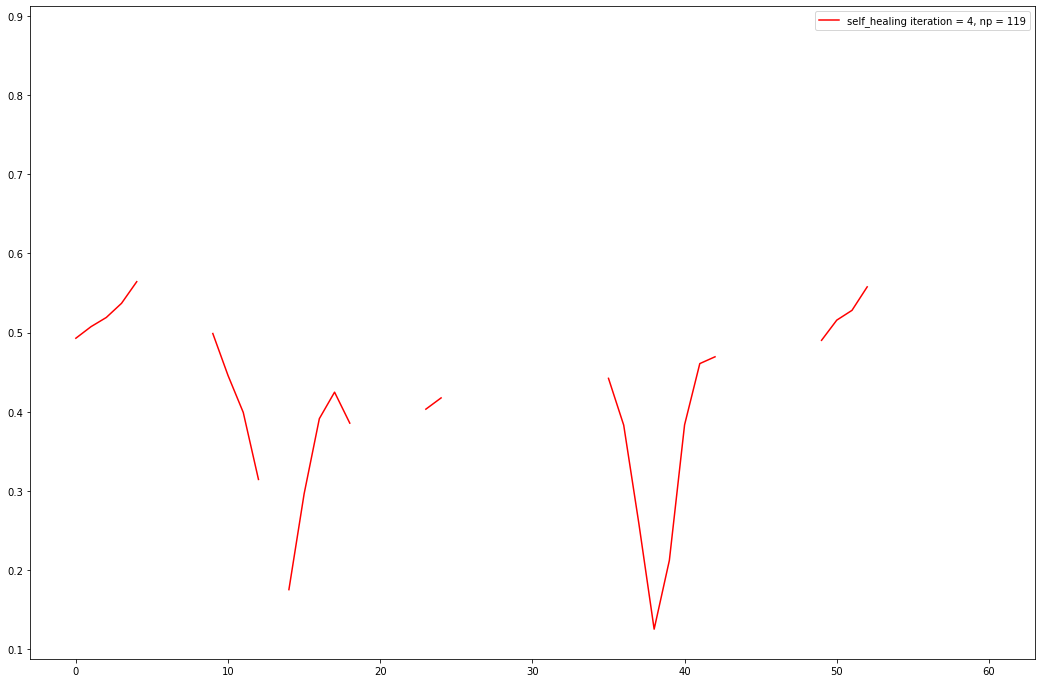

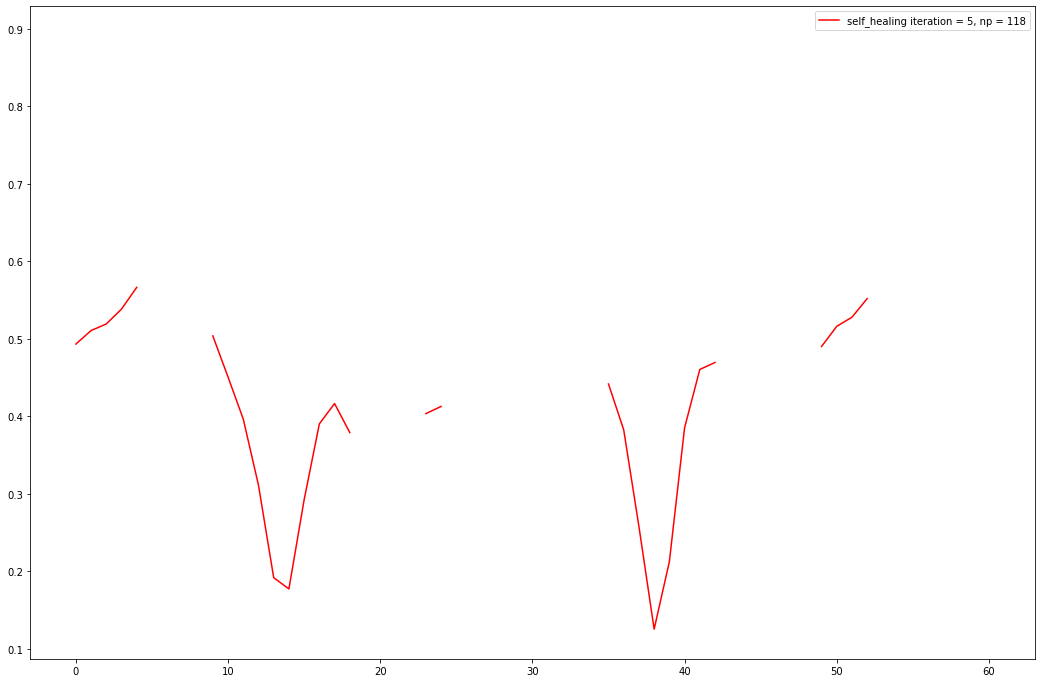

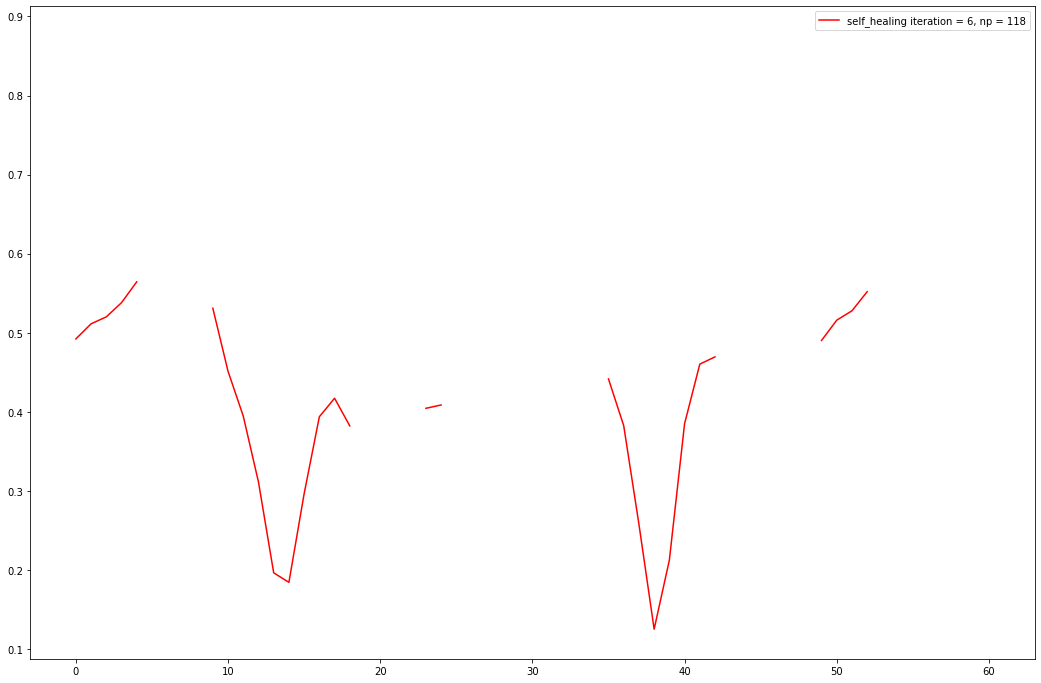

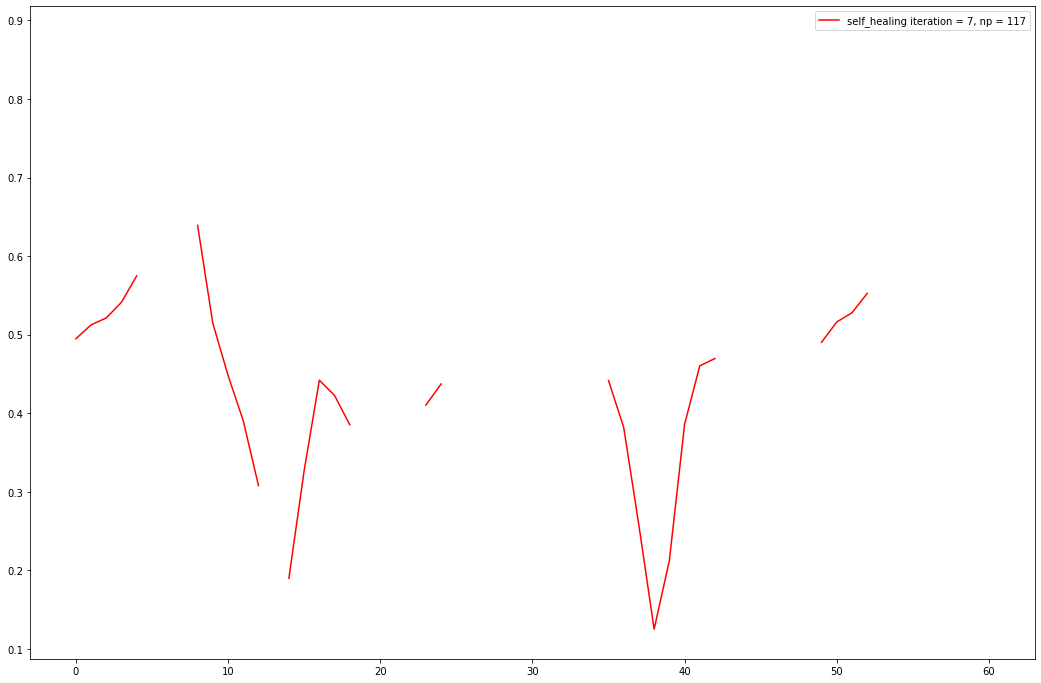

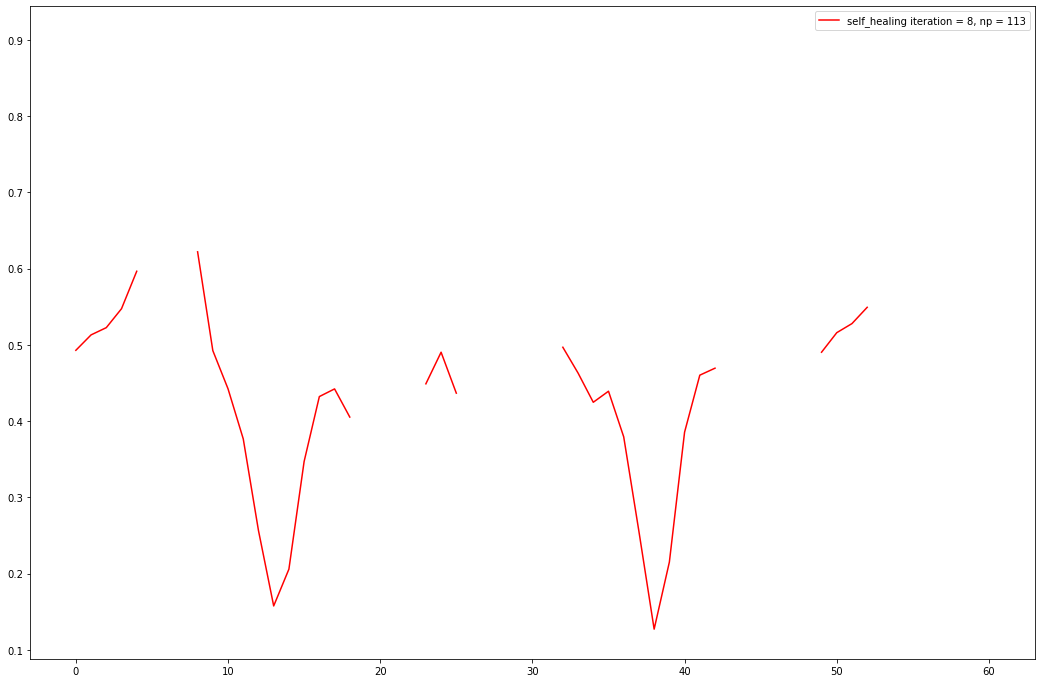

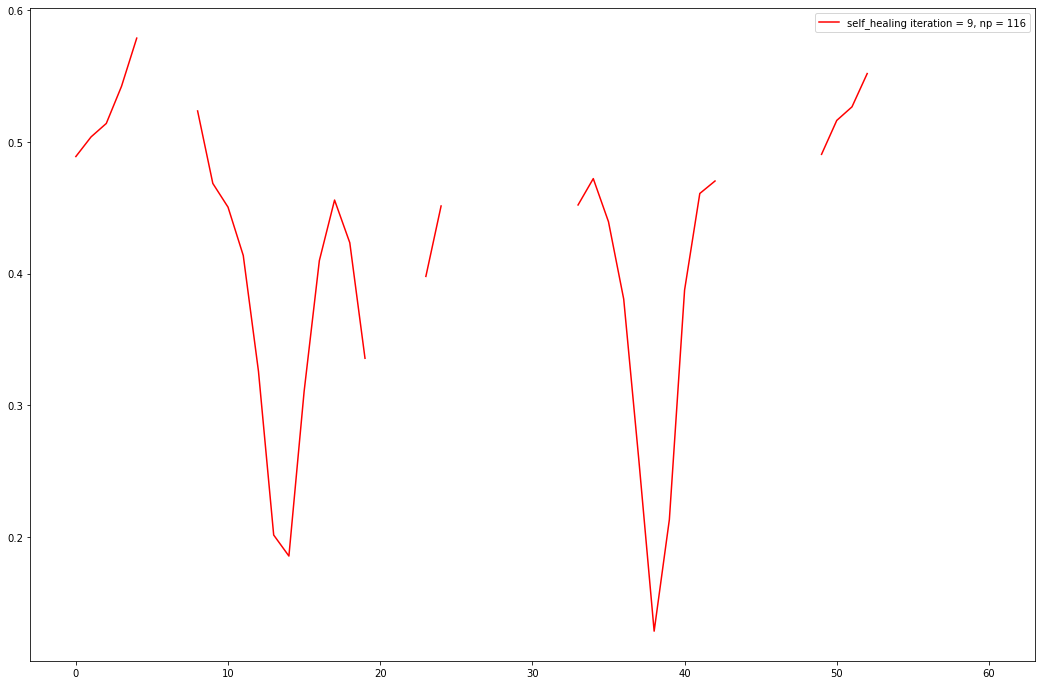

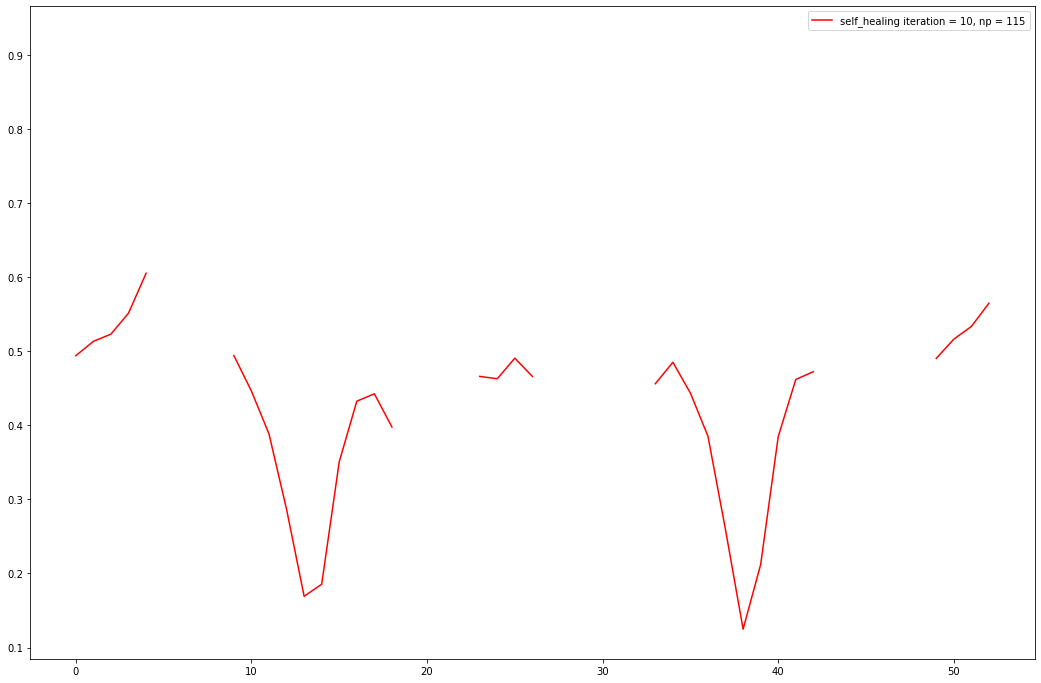

In [212]:
for i in range(11):
    pred_a = np.load(f"self_healing_15000_reset_q/pred_iter={i}.npy", allow_pickle=True)
    bad_b = np.load(f"self_healing_15000_reset_q/bad_iter={i}.npy", allow_pickle=True)
    visualize_predictions(train_data, pred_a, test_data, 150, bad_b, label=f"self_healing iteration = {i}, np = {sum(bad_b[-150:])}")